# Tidying masks post process

In [56]:
from octopuslite import DaskOctopusLiteLoader
import btrack
from tqdm.auto import tqdm
import numpy as np
from scipy.special import softmax
import os
import matplotlib.pyplot as plt
from skimage.io import imread, imshow, imsave
from cellx import load_model
from cellx.tools.image import InfinitePaddedImage
from skimage.transform import resize
import glob
from natsort import natsorted
from tqdm import trange
from skimage.measure import label, regionprops
%matplotlib inline
plt.rcParams['figure.figsize'] = [18,8]

## 1. Load segmentation images

#### *Important:* from this point on you will need to be consistent with the use of cropping and alignment. 
Using a previously generated alignment transformation will aid greatly in the tracking notebook, which depends on the object localisation performed in this notebook. Cropping your images will ensure that no border effects from the translational shift are seen. 

In [116]:
# load images
expt = 'ND0018'
pos = 'Pos9'
root_dir = '/home/nathan/data/kraken/ras'
image_path = f'{root_dir}/{expt}/{pos}/{pos}_images'
transform_path = f'{root_dir}/{expt}/{pos}/transform_tensor.npy'
images = DaskOctopusLiteLoader(image_path, 
                               transforms=transform_path,
                               crop=(1200,1600), 
                               remove_background=True)

Using cropping: (1200, 1600)


In [3]:
images.channels

[<Channels.BRIGHTFIELD: 0>,
 <Channels.GFP: 1>,
 <Channels.RFP: 2>,
 <Channels.IRFP: 3>,
 <Channels.MASK_GFP: 98>,
 <Channels.MASK: 99>]

In [11]:
from skimage.io import imshow

/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


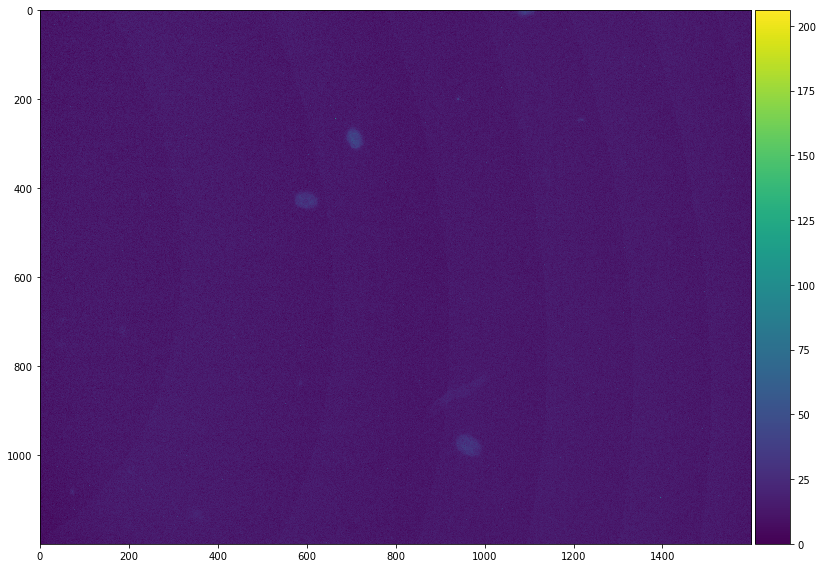

In [17]:
imshow((images['rfp'][0]).astype(np.uint8)*2)

/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


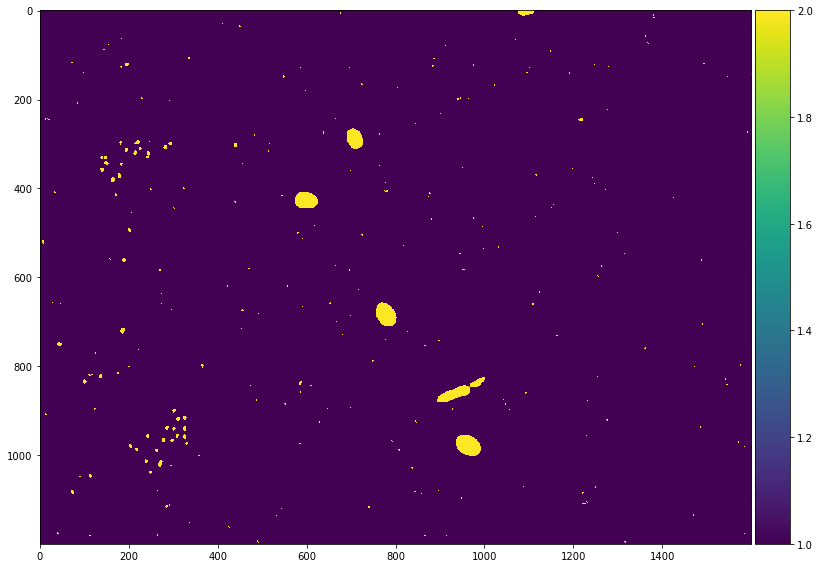

In [14]:
imshow(((images['mask'][0]==2)+1).astype(np.uint8))

/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


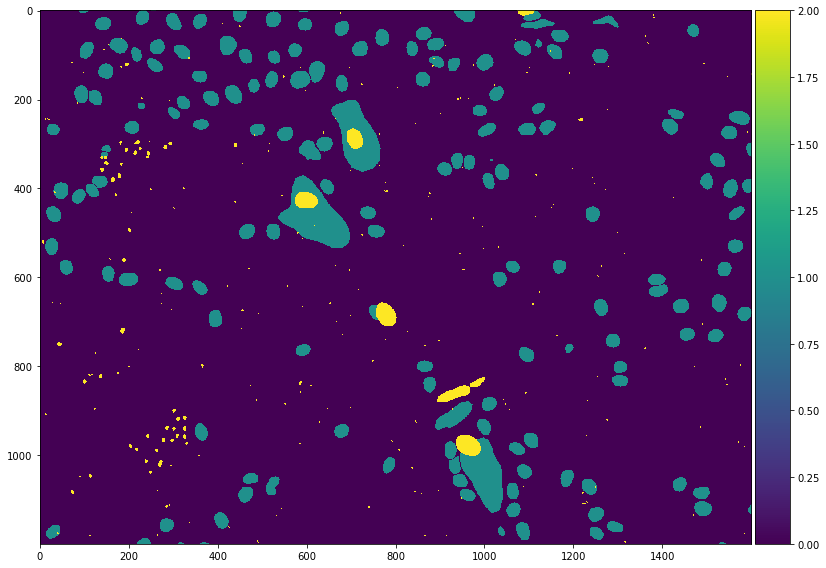

In [369]:
imshow(images['mask'][0])

In [29]:
import scipy.ndimage as ndi

In [43]:
labels, n = ndi.label(images['mask'][0])

In [59]:
# labeling : each region is associated with an int
labels, n = ndi.label(images['mask'][0]==2)
# provide bounding box for each region in the form of tuples of slices
objects = ndi.find_objects(labels)

In [60]:
n

281

In [45]:
objects[0]

(slice(0, 13, None), slice(1073, 1112, None))

/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


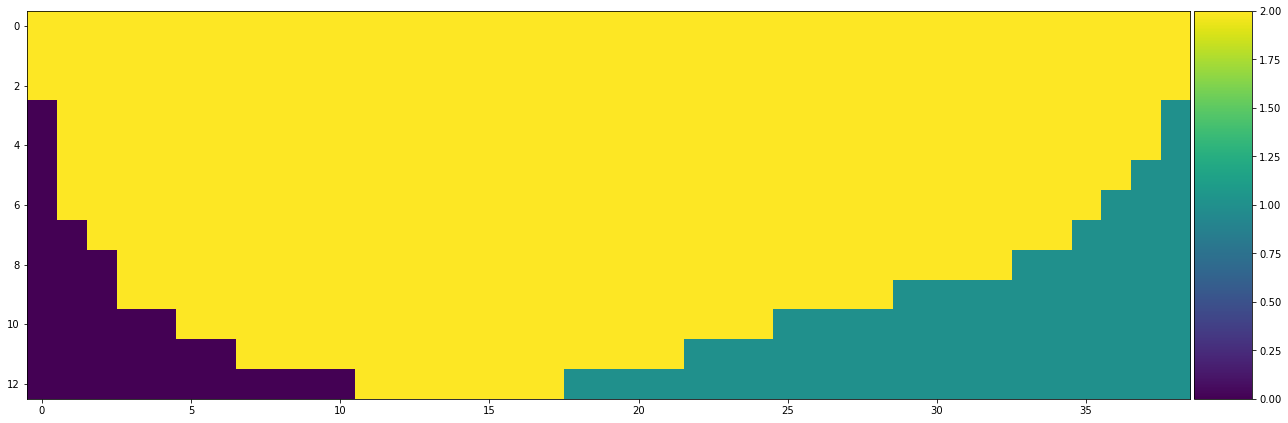

In [49]:
imshow(images['mask'][0][objects[0]])

In [51]:
np.sum(images['mask'][0][objects[0]]).compute()

865.0

In [52]:
images['mask'][0][objects[0]].shape

(13, 39)

In [53]:
13*39

507

In [61]:
# labeling : each region is associated with an int
labels, n = ndi.label(images['mask'][0])
# provide bounding box for each region in the form of tuples of slices
objects = ndi.find_objects(labels)

In [55]:
objects[0]

(slice(0, 7, None), slice(87, 113, None))

In [58]:
n

422

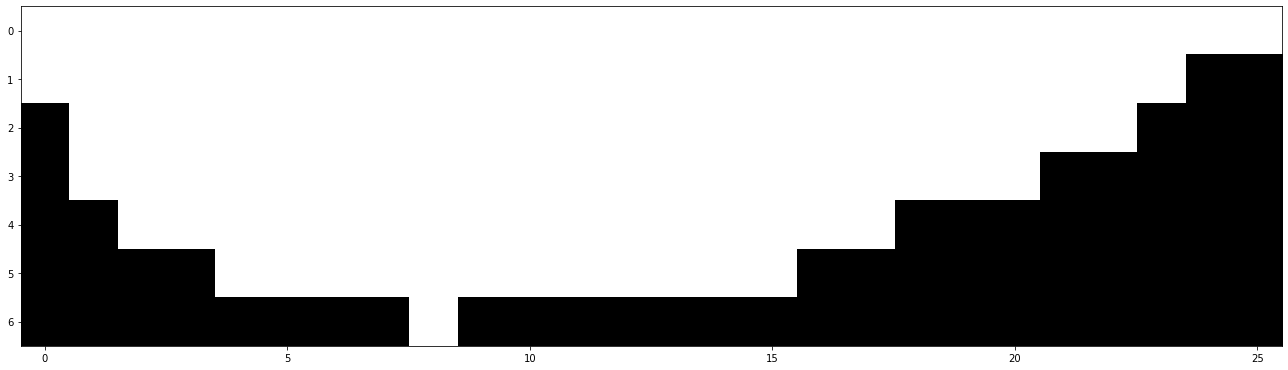

In [65]:
imshow(images['mask'][0][objects[0]])

In [62]:
np.sum(images['mask'][0][objects[0]]).compute()

121.0

In [63]:
images['mask'][0][objects[0]].shape

(7, 26)

In [64]:
7*26

182

In [ ]:
imshow(segment[.astype(int))

/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


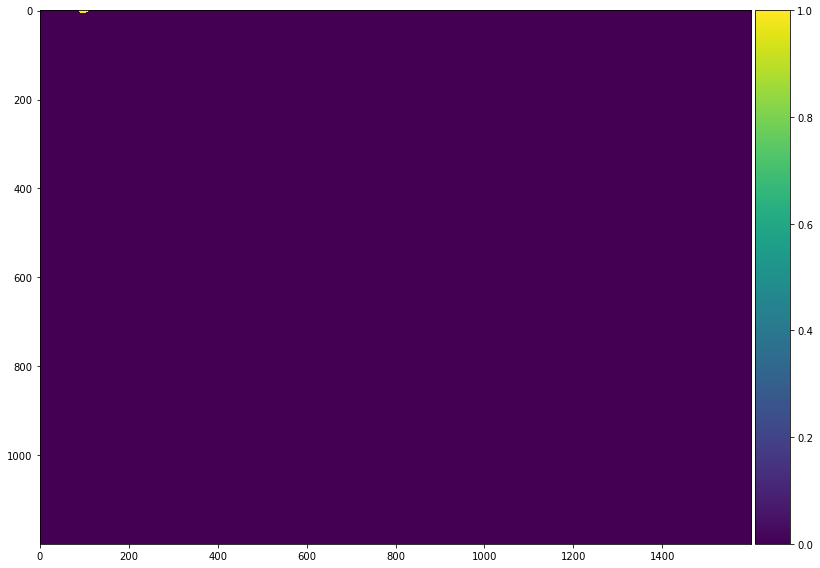

In [28]:
imshow(segment.astype(int))

In [211]:
from skimage.measure import label, regionprops
from skimage.morphology import binary_erosion

In [72]:
regionprops(label(images['mask'][0]==2))[0].area

393

/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


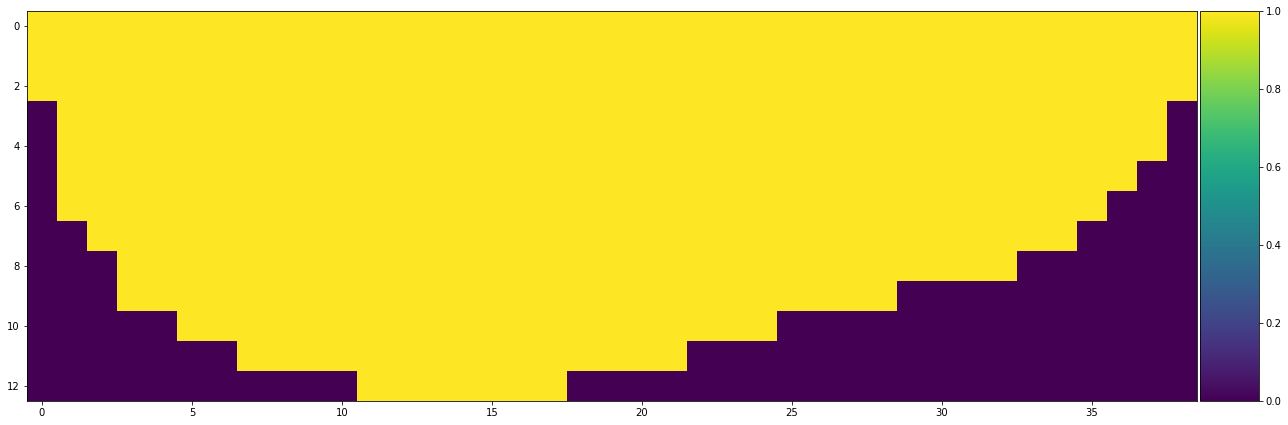

In [77]:
imshow((regionprops(label(images['mask'][0]==2))[0].image).astype(int))

In [79]:
coords = regionprops(label(images['mask'][0]==2))[0].coords

In [82]:
mask = (images['mask'][0] == 2).astype(int)

/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


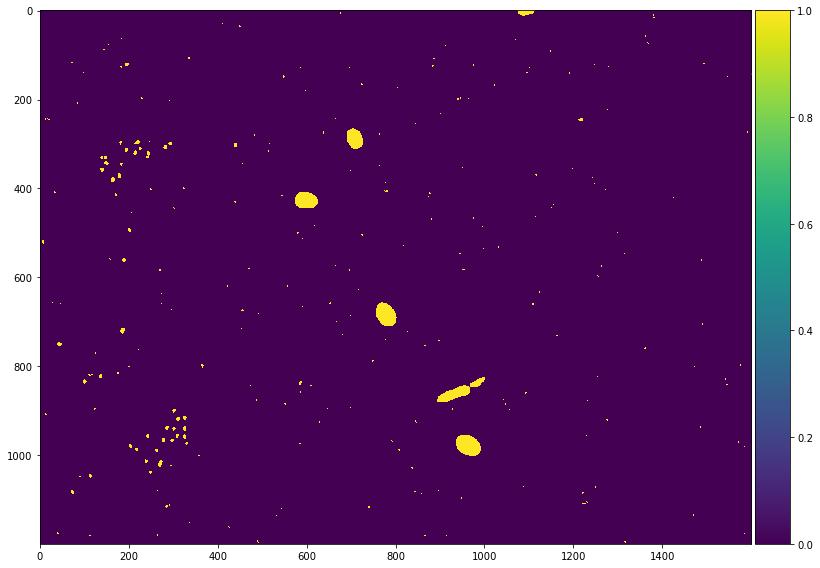

In [83]:
imshow(mask)

In [85]:
for coord in coords:
    mask[coord] = 0

In [97]:
tuple(coord)

(12, 1090)

In [94]:
mask[12,1090].compute()

0

In [98]:
mask[tuple(coord)].compute()

0

In [99]:
mask[coord].compute()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [125]:
type(mask)

numpy.ndarray

In [184]:
mask = (images['mask'][0]).compute().astype(int)

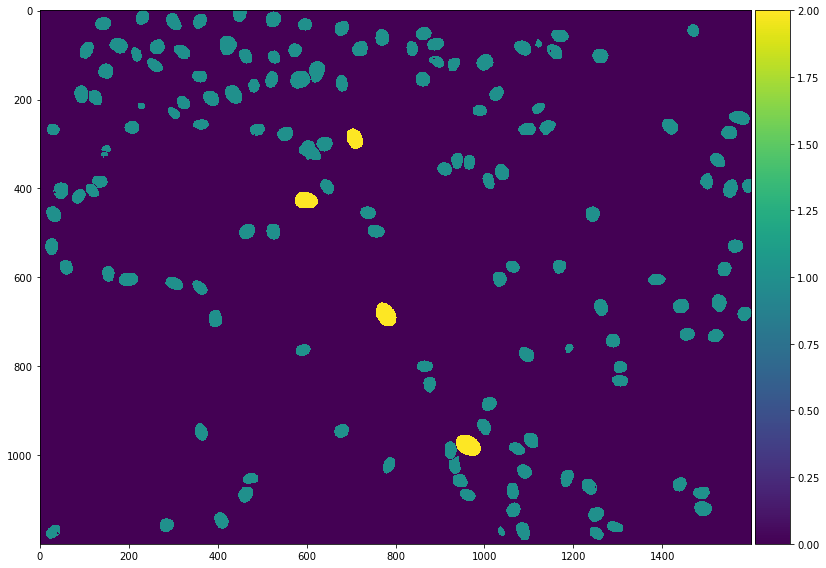

In [192]:
mask = (images['mask'][0]).compute().astype(int)
for region in regionprops(label(mask)):
    if 4000 <= region.area or region.area <= 100 or region.eccentricity > 0.8:
        for coord in region.coords:
            mask[tuple(coord)] = 0
imshow(mask)

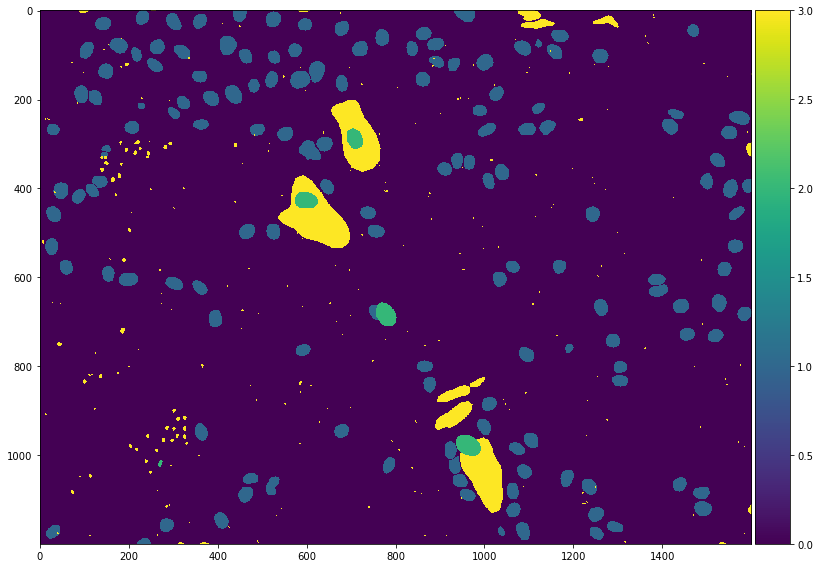

In [197]:
imshow(((images['mask'][0]==2)+1).astype(np.uint8))mask = (images['mask'][0]).compute().astype(int)
for region in regionprops(label(mask)):
    if 4000 <= region.area or region.area <= 100 or region.eccentricity > 0.9:
        for coord in region.coords:
            mask[tuple(coord)] = 3
imshow(mask)

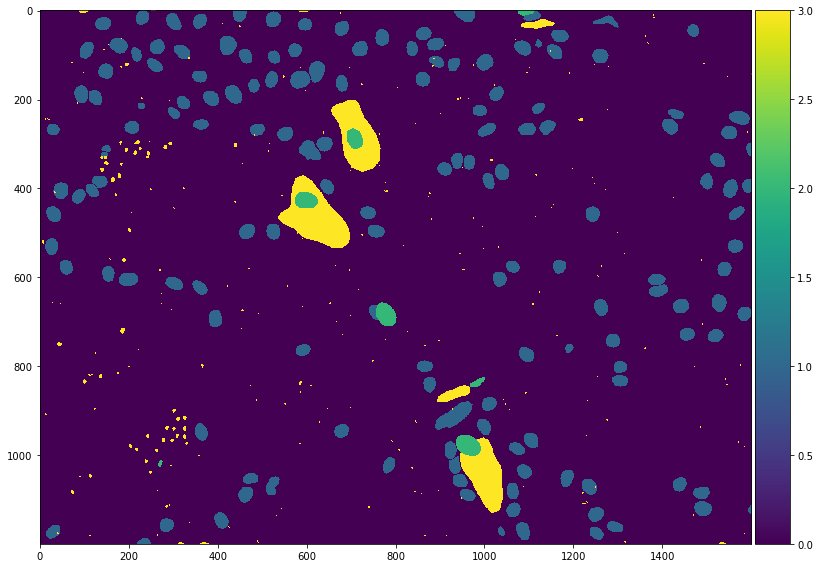

In [198]:
mask = (images['mask'][0]).compute().astype(int)
for region in regionprops(label(mask)):
    if 4000 <= region.area or region.area <= 100 or region.eccentricity > 0.95:
        for coord in region.coords:
            mask[tuple(coord)] = 3
imshow(mask)

In [202]:

mask = np.zeros((5,1200,1600))
for i in range(5):
    mask[i] = (images['mask'][i]).compute().astype(int)
    for region in regionprops(label(mask[i])):
        if 4000 <= region.area or region.area <= 100 or region.eccentricity > 0.95:
            for coord in region.coords:
                mask[i][tuple(coord)] = 3

/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


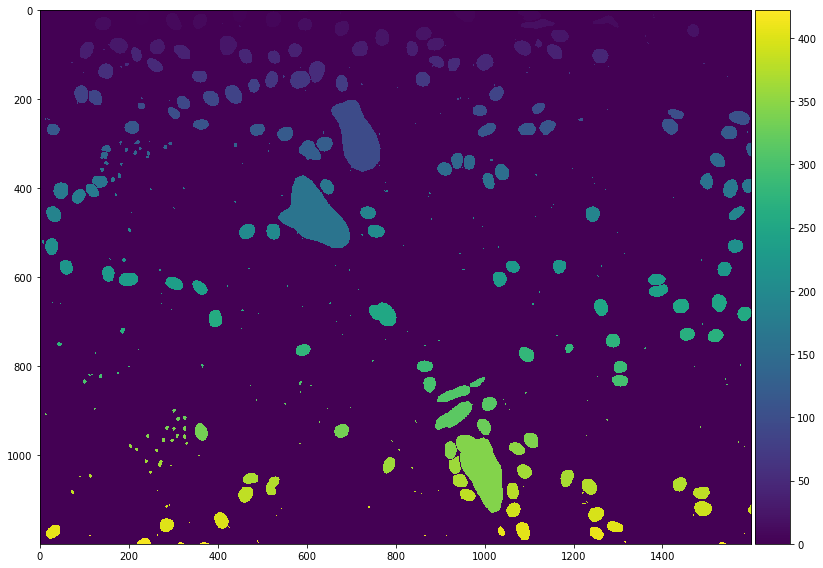

In [209]:
imshow(labels)

In [ ]:
import ndimage

In [240]:
labels = label(images['mask'][0]==1)

# format 2channel mask image and post process
mask = np.zeros(labels.shape)

for i in range(1, np.amax(labels)):
    #needs erosion step to stop merging of labels
    segment = binary_erosion(labels==i)
    mask[segment] = 1 ## for gfp
    seg_props = regionprops(label(segment))[0]
    if 4000 <= seg_props.area or seg_props.area <= 100 or seg_props.eccentricity > 0.95:
         for coord in region.coords:
                mask[tuple(coord)] = 3
#     # set background to zero
#     mask[labels == 0] = 0

# # now do the same for the rfp channel
# rfp = imread(fn.replace('channel001', 'channel002'))   
# # predict labels using 2 instances of the model with different params
# labels, details = seg_model.predict_instances(normalize(rfp), prob_thresh=0.2)
labels = label(images['mask'][0]==2)
for i in range(1, np.amax(labels)):
    #needs erosion step to stop merging of labels
    segment = binary_erosion(labels==i)
    mask[segment] = 2 ## for rfp
    seg_props = regionprops(label(segment))[0]
    if 4000 <= seg_props.area or seg_props.area <= 100 or seg_props.eccentricity > 0.95:
         for coord in region.coords:
                mask[tuple(coord)] = 3

### post processing of images

IndexError: list index out of range

In [241]:
i

4

In [242]:
segment

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


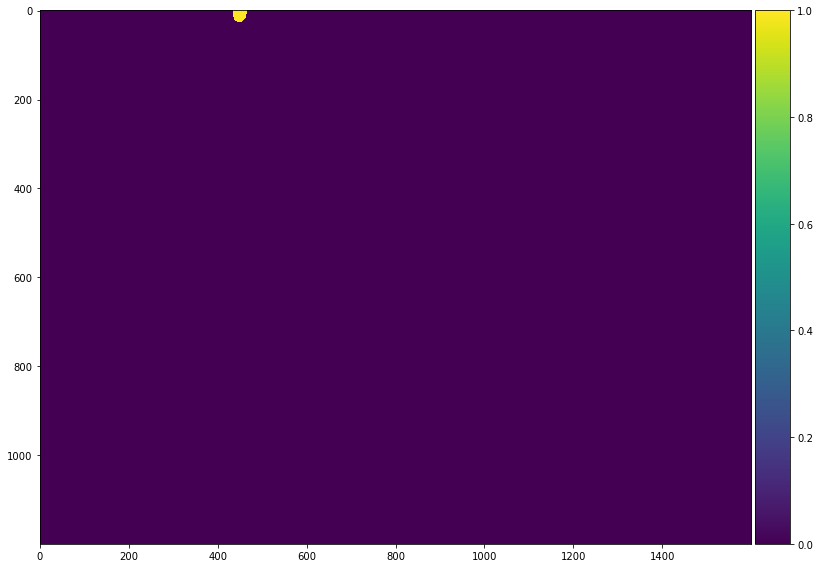

In [246]:
imshow((label(images['mask'][0]==1)==4).astype(int))

In [250]:
import scipy.ndimage as nd

In [253]:
i

4

/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


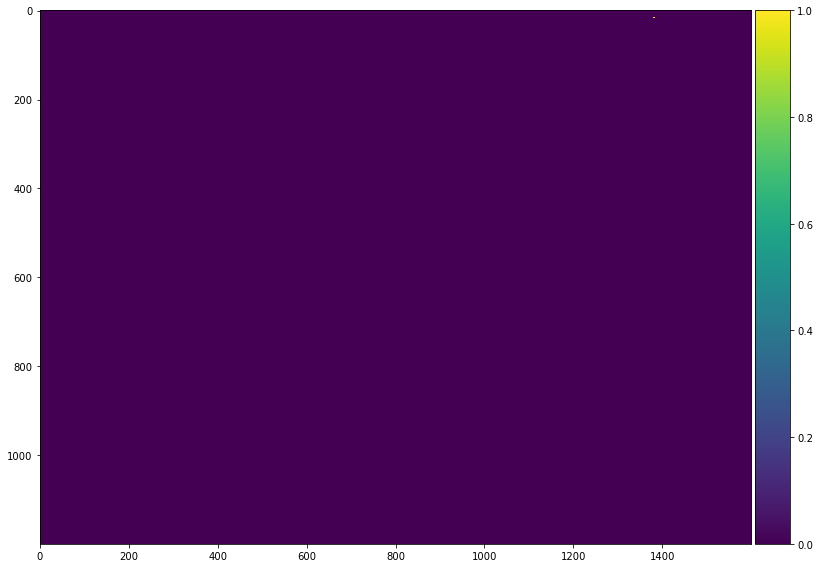

In [258]:
imshow((labels==i).astype(int))

In [256]:
segment = binary_erosion((labels==i).astype(int))

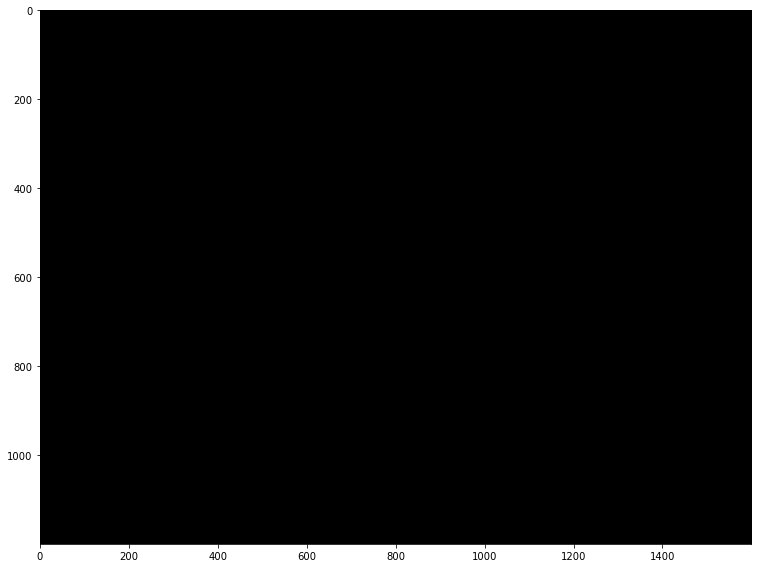

In [257]:
imshow(segment.astype(int))

# fails bc erosion deletes small item

In [259]:
segment = labels == i

/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


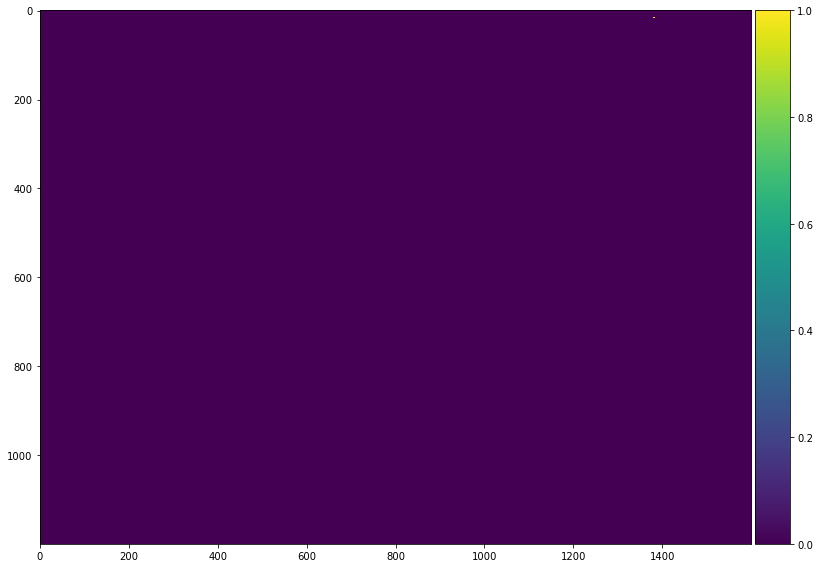

In [261]:
imshow(segment.astype(int))

In [262]:
seg_props = regionprops(label(segment))

In [265]:
seg_props[0].area

6

In [276]:
labels = label(images['mask'][0]==1)

# format 2channel mask image and post process
mask = np.zeros(labels.shape)

for i in range(1, np.amax(labels)):
    #needs erosion step to stop merging of labels
    segment = labels == i
    seg_props = regionprops(label(segment))[0]
    if 4000 <= seg_props.area or seg_props.area <= 100 or seg_props.eccentricity > 0.95:
        mask[segment] = 3
    else:
        segment = binary_erosion(segment)
        mask[segment] = 1

labels = label(images['mask'][0]==2)
for i in range(1, np.amax(labels)):
    #needs erosion step to stop merging of labels
    segment = labels == i
    seg_props = regionprops(label(segment))[0]
    if 4000 <= seg_props.area or seg_props.area <= 100 or seg_props.eccentricity > 0.95:
        mask[segment] = 3
    else:
        segment = binary_erosion(segment)
        mask[segment] = 2

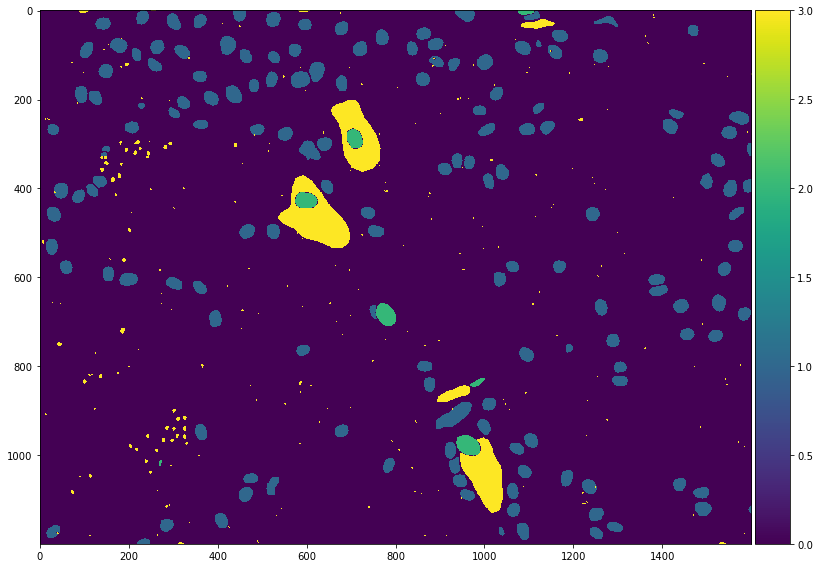

In [325]:
imshow(mask)

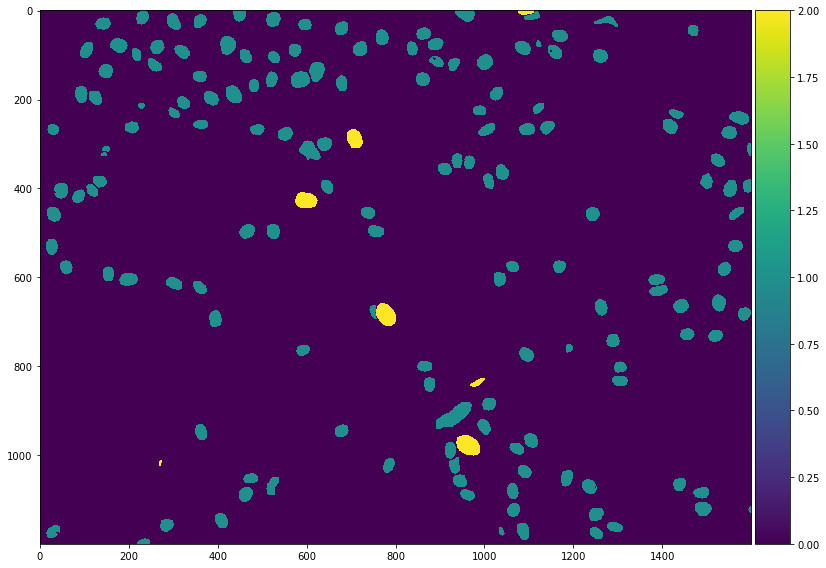

In [291]:
imshow((mask==1).astype(int)+(mask==2).astype(int)*2)

In [326]:
mask_2 = np.zeros((2,1200,1600))

In [327]:
mask_2[0] = mask
mask_2[1] = mask

In [338]:
images['mask'][0]

dask.array<getitem, shape=(1200, 1600), dtype=float32, chunksize=(1200, 1600), chunktype=numpy.ndarray>

In [341]:
from skimage.io import imsave

In [342]:
help(imsave)

Help on function imsave in module skimage.io._io:

imsave(fname, arr, plugin=None, check_contrast=True, **plugin_args)
    Save an image to file.
    
    Parameters
    ----------
    fname : str
        Target filename.
    arr : ndarray of shape (M,N) or (M,N,3) or (M,N,4)
        Image data.
    plugin : str, optional
        Name of plugin to use.  By default, the different plugins are
        tried (starting with imageio) until a suitable
        candidate is found.  If not given and fname is a tiff file, the
        tifffile plugin will be used.
    check_contrast : bool, optional
        Check for low contrast and print warning (default: True).
    
    Other Parameters
    ----------------
    plugin_args : keywords
        Passed to the given plugin.
    
    Notes
    -----
    When saving a JPEG, the compression ratio may be controlled using the
    ``quality`` keyword argument which is an integer with values in [1, 100]
    where 1 is worst quality and smallest file size, 

In [1]:
import glob

In [2]:
files = glob.glob('/home/nathan/data/kraken/ras/ND00**/Pos*/Pos*_images/*channel098*')

In [3]:
int(len(files)/4)

7855

In [4]:
from tqdm.auto import tqdm
import os

In [5]:
files[0]

'/home/nathan/data/kraken/ras/ND0013/Pos8/Pos8_images/img_channel098_position008_time000000158_z000.tif'

In [6]:
from skimage.io import imread, imsave

In [7]:
from skimage.measure import label, regionprops
from skimage.morphology import binary_erosion

In [8]:
from natsort import natsorted
import numpy as np

In [9]:
files = natsorted(files[0:1*int(len(files)/4)])

In [15]:
for fn in tqdm(files, total = len(files)):
    
    if os.path.exists(fn.replace('channel098', 'channel099')):
        continue
    input_mask = imread(fn)
    labels = label(input_mask==1)

    # format 2channel mask image and post process
    mask = np.zeros(labels.shape, dtype = np.uint8)

    ### image post processing 
    for i in range(1, np.amax(labels)):
        #needs erosion step to stop merging of labels
        segment = labels == i
        seg_props = regionprops(label(segment))[0]
        if 4000 <= seg_props.area or seg_props.area <= 100 or seg_props.eccentricity > 0.95:
            #segment = binary_erosion(segment)
            mask[segment] = 3
        else:
            #segment = binary_erosion(segment)
            mask[segment] = 1

    labels = label(input_mask==2)
    
    ### image post processing 
    for i in range(1, np.amax(labels)):
        #needs erosion step to stop merging of labels
        segment = labels == i
        seg_props = regionprops(label(segment))[0]
        if 4000 <= seg_props.area or seg_props.area <= 100 or seg_props.eccentricity > 0.95:
            #segment = binary_erosion(segment)
            mask[segment] = 3
        else:
            #segment = binary_erosion(segment)
            mask[segment] = 2
            
    imsave(fn.replace('channel098', 'channel099'), mask.astype(np.uint8), check_contrast=False)



  0%|          | 0/7855 [00:00<?, ?it/s]

KeyboardInterrupt: 

# final post processing steps

1. Morpho closing
2. If rfp nucleus in gfp cell then assign 3

In [12]:
# load images
expt = 'ND0013'
pos = 'Pos7'
root_dir = '/home/nathan/data/kraken/ras'
image_path = f'{root_dir}/{expt}/{pos}/{pos}_images'
transform_path = f'{root_dir}/{expt}/{pos}/transform_tensor.npy'
images = DaskOctopusLiteLoader(image_path, 
                               #transforms=transform_path,
                               #crop=(1200,1600), 
                               #remove_background=True
                              )

In [13]:
masks = images['mask']

In [14]:
mask = masks[2667]

/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)
/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


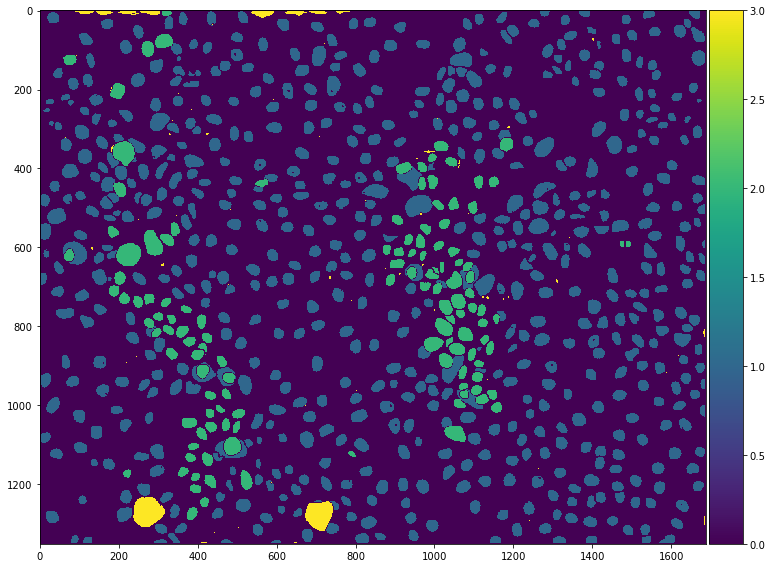

In [15]:
imshow(mask)

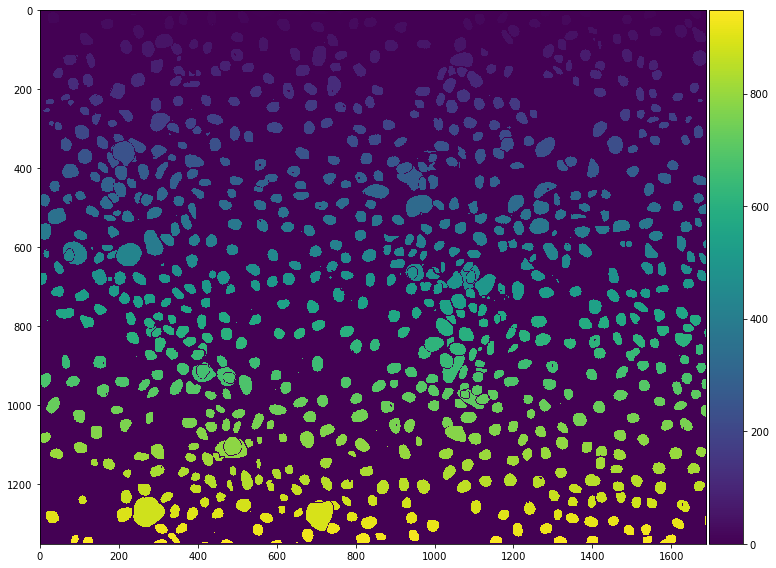

In [16]:
imshow(label(mask))

In [17]:
g_mask = mask == 1

In [18]:
r_mask = mask == 2

/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


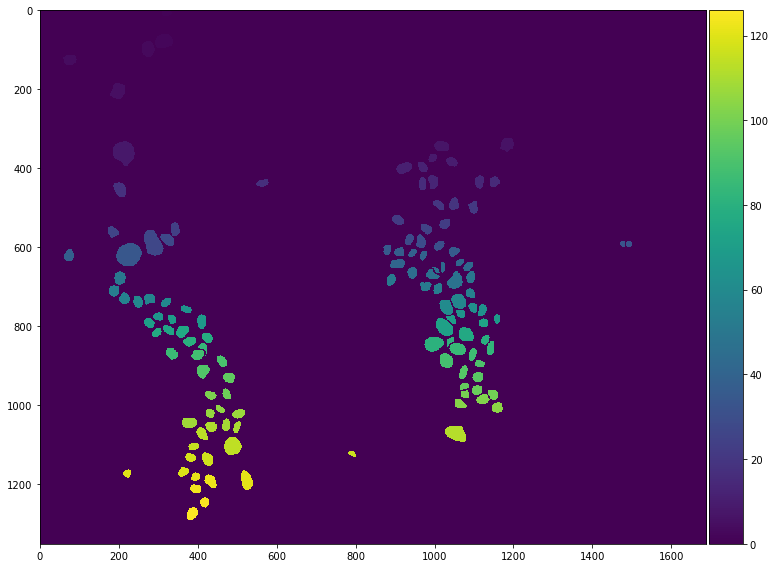

In [19]:
imshow(label(r_mask))

In [20]:
# mean area of rfp nucleus
np.mean([prop.area for prop in regionprops(label(r_mask))])

657.9444444444445

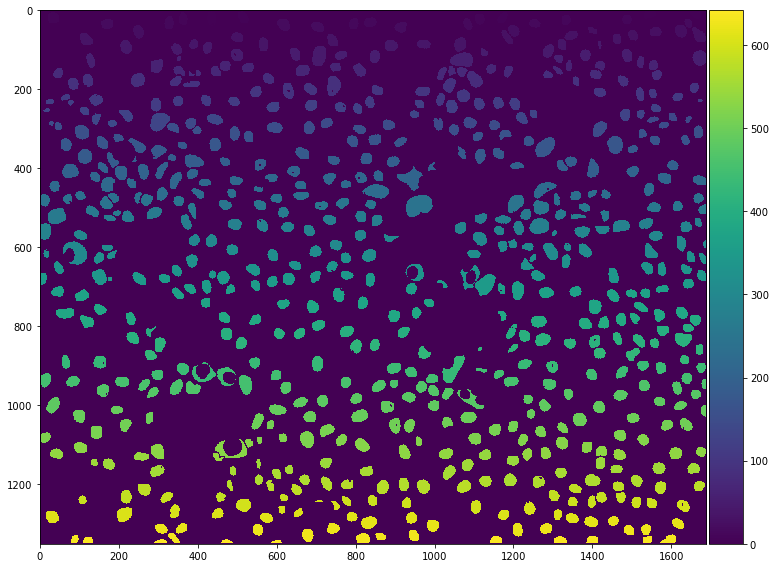

In [21]:
imshow(label(g_mask))

In [22]:
from skimage.morphology import diameter_closing

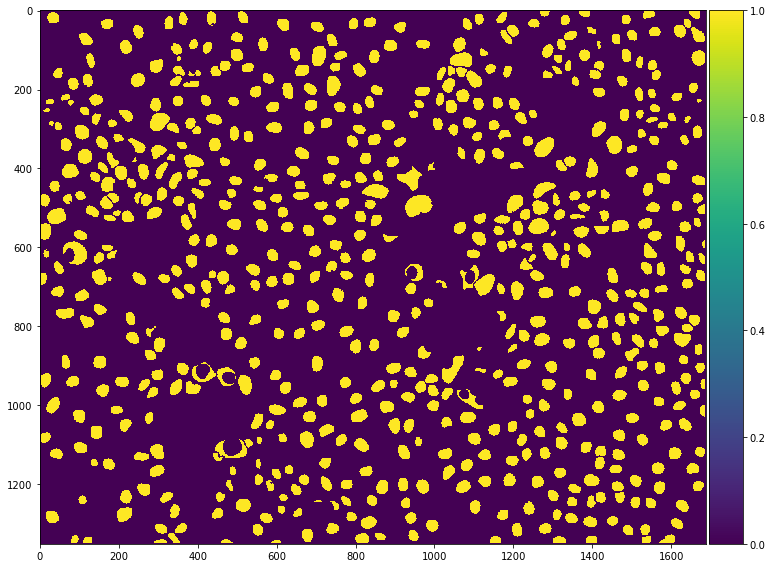

In [23]:
imshow(diameter_closing(g_mask.compute(), diameter_threshold= 700).astype(int))

In [24]:
g_mask_2 = np.zeros(g_mask.shape)
for ID in [segment.label for segment in regionprops(label(g_mask)) 
          # if segment.area > 4000 or segment.area < 100 or 
           if segment.eccentricity > 0.95]:
    segment = g_mask == ID
    g_mask_2[segment] = 3

In [25]:
[(segment.label, segment.area, segment.centroid) for segment in regionprops(label(g_mask)) if  segment.eccentricity > 0.95]

[(271, 379, (522.4300791556728, 1360.4036939313985)),
 (454, 7, (929.0, 495.0)),
 (462, 2, (935.5, 494.0)),
 (598, 87, (1242.7471264367816, 704.3563218390805)),
 (640, 269, (1345.3197026022306, 305.64684014869886)),
 (642, 172, (1346.2325581395348, 598.9069767441861))]

In [26]:
print(g_mask == 271)

dask.array<eq, shape=(1352, 1688), dtype=bool, chunksize=(1352, 1688), chunktype=numpy.ndarray>


/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


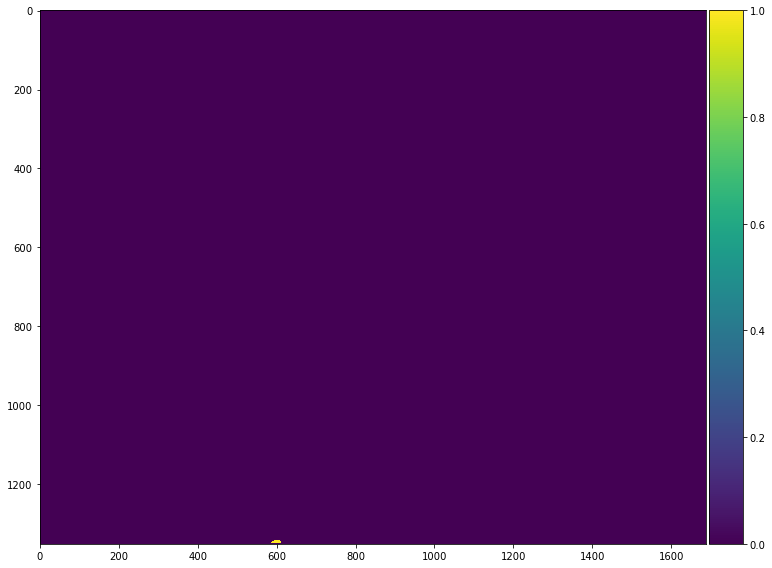

In [27]:
imshow((label(g_mask) == 642).astype(int))

In [28]:
regionprops(label(g_mask))[100].

SyntaxError: invalid syntax (<ipython-input-28-7560b71c12c7>, line 1)

In [ ]:
imshow(segment.astype(int))

# i dont think i will exclude donuts based on area or ellipse

# excluding donuts based on overlap

In [ ]:
imshow(g_mask)

In [ ]:
from skimage.morphology import dilation

In [ ]:
r_mask = r_mask.compute().astype(np.uint8)

In [ ]:
imshow(dilation(r_mask))

In [32]:
from skimage import segmentation as seg

In [ ]:
imshow(seg.expand_labels(r_mask, distance = 3))

In [ ]:
r_mask_fat = seg.expand_labels(r_mask, distance = 3)

In [ ]:
g_mask = g_mask.compute().astype(int)

In [ ]:
imshow(g_mask+r_mask_fat*2)

In [ ]:
imshow(seg.join_segmentations(g_mask, r_mask_fat))

In [ ]:
combined = g_mask+r_mask_fat*2

In [ ]:
imshow((combined ==3).astype(int))

In [ ]:
np.amax(label(g_mask))

In [ ]:
segment.compute()

In [ ]:
overlap = combined == 3

In [ ]:
imshow(mask)

In [ ]:
imshow(mask)

In [ ]:
mask

In [236]:
g_mask_2 = mask.compute().astype(int)
for ID in range(1, np.amax(label(g_mask))):
    segment = label(g_mask) == ID
    #if a pixel value of 3 is in the region g_mask[segment]
    if 1 in overlap[segment]:
        g_mask_2[segment] = 3

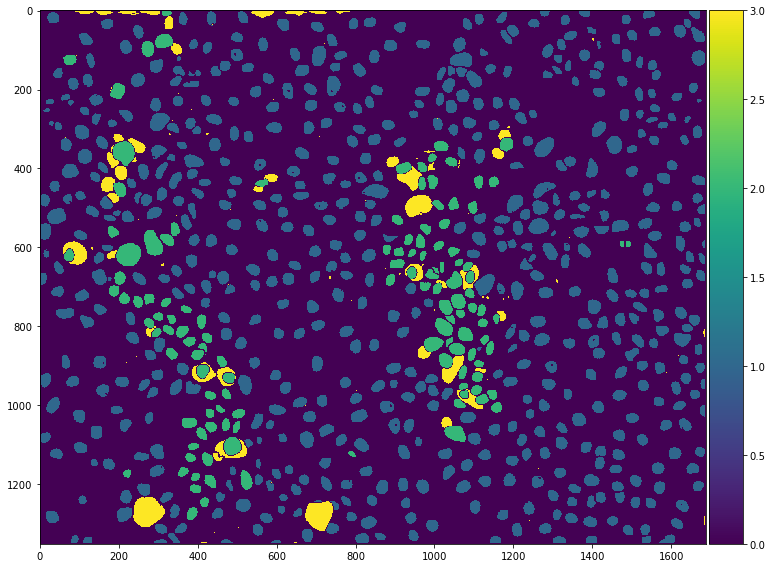

In [237]:
imshow(g_mask_2)

# looks like ive identified touching gfp and rfp regions

1. dilate rfp masks so that they touch gfp masks if neighbouring
1.5. create overlap image
2. label gfp mask image and iterate over segments
3. if segment contains overlap image pixels = 1 then reassign

In [29]:
### running on test image for nd18.11

# load images
expt = 'ND0018'
pos = 'Pos11'
root_dir = '/home/nathan/data/kraken/ras'
image_path = f'{root_dir}/{expt}/{pos}/{pos}_images'
transform_path = f'{root_dir}/{expt}/{pos}/transform_tensor.npy'
images = DaskOctopusLiteLoader(image_path, 
                               #transforms=transform_path,
                               #crop=(1200,1600), 
                               #remove_background=True)
                              )

In [30]:
images.channels

[<Channels.BRIGHTFIELD: 0>,
 <Channels.GFP: 1>,
 <Channels.RFP: 2>,
 <Channels.IRFP: 3>,
 <Channels.MASK_RFP: 97>,
 <Channels.MASK_GFP: 98>,
 <Channels.MASK: 99>]

In [39]:
files = images.files('mask')
for fn in tqdm(files):
    mask = imread(fn).astype(np.uint8)
    gfp_mask = (mask == 1).astype(np.uint8)
    rfp_mask = (mask == 2).astype(np.uint8)
    rfp_mask_exp = seg.expand_labels(rfp_mask, distance = 3) # might need to be 3 for double eroded
    overlap = ((gfp_mask + rfp_mask_exp*2) == 3).astype(np.uint8)
    gfp_mask_labeled = label(gfp_mask)
    for ID in range(1, np.amax(gfp_mask_labeled)):
        segment = gfp_mask_labeled == ID
        #if a pixel value of 3 is in the region g_mask[segment]
        if 1 in overlap[segment]:
            mask[segment] = 3
    mask = area_closing(mask)
    
    imsave(fn.replace('channel099', 'channel096'), mask.astype(np.uint8), check_contrast = False)

  0%|          | 0/394 [00:00<?, ?it/s]

In [36]:
from skimage.morphology import area_closing

/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


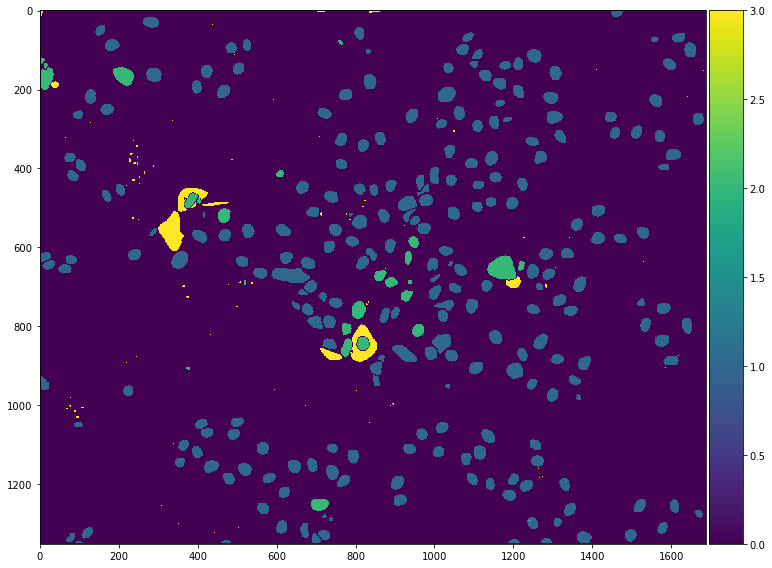

In [37]:
### fill holes
imshow(area_closing(mask))

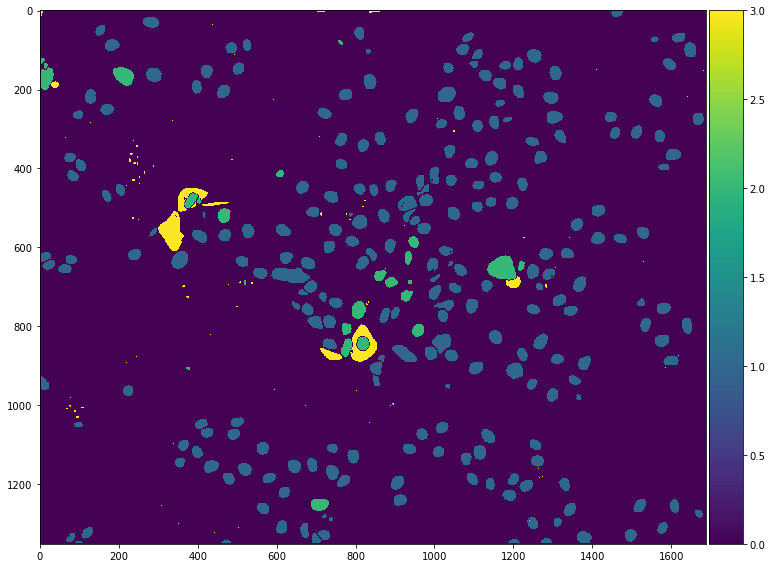

In [267]:
imshow(mask)

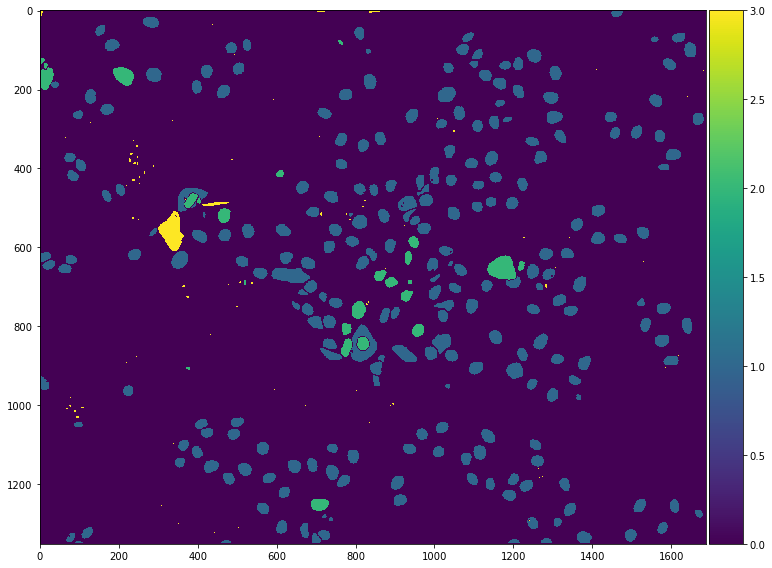

In [244]:
#want the following image to show the donuts as yellow too
imshow(mask)

# The whole biscuit

Performing all the image post processing on already segmented images



In [142]:
import glob
from skimage.measure import label, regionprops
from skimage.morphology import binary_erosion, area_closing, binary_closing
from skimage.segmentation import expand_labels
from skimage.io import imread, imshow, imsave
from scipy.ndimage.morphology import binary_fill_holes
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

In [3]:
files = glob.glob('/home/nathan/data/kraken/ras/ND00**/Pos*/Pos*_images/*channel098*')

In [4]:
len(files)

31423

/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


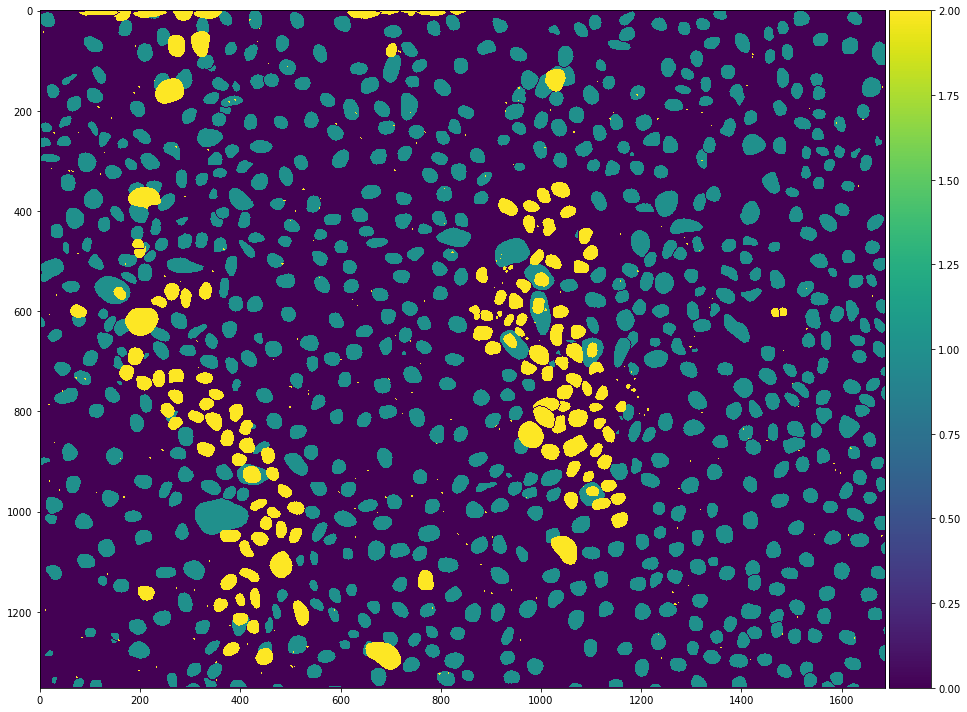

In [5]:
imshow(imread(files[3000]))

In [6]:
mask = imread(files[3000])

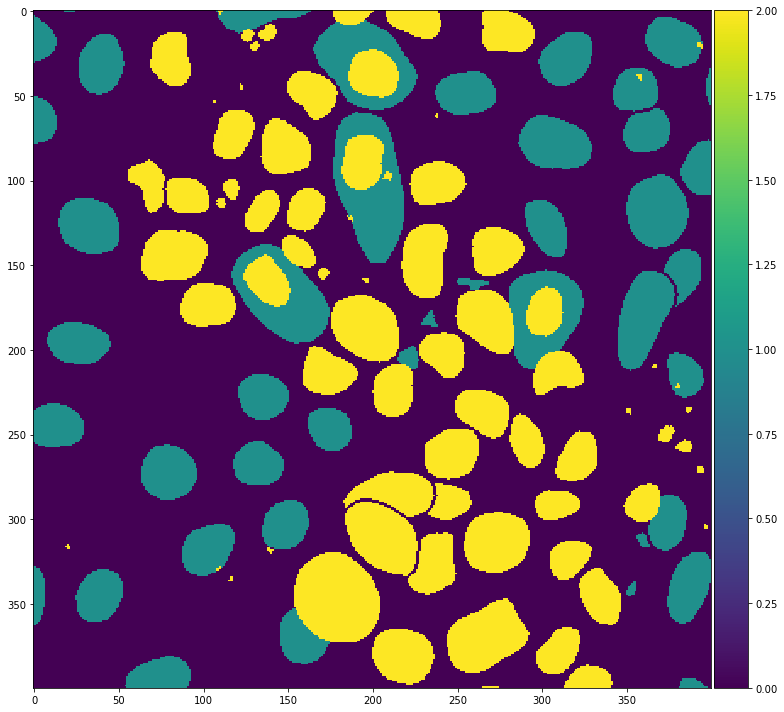

In [7]:
imshow(mask[500:900,800:1200])

In [101]:
# this how stardist supplies the masks
mask = (imread(files[3000]))
gfp_mask = label((mask == 1).astype(np.uint8))
rfp_mask = label((mask == 2).astype(np.uint8))

### RFP image post processing 
for i in range(1, np.amax(rfp_mask)):
    #needs erosion step to stop merging of labels
    segment = rfp_mask == i
    seg_props = regionprops(label(segment))[0]
    if seg_props.area <= 150:
        mask[segment] = 0
        ## dont think i need this section as the gfp segments are problematic for these reasons
#     if 3000 <= seg_props.area or seg_props.area <= 150 or seg_props.eccentricity > 0.95:
#         #segment = binary_erosion(segment)
#         mask[segment] = 3
    else:
        #segment = binary_erosion(segment)
        mask[segment] = 2
gfp_mask = label(binary_fill_holes(gfp_mask).astype(np.uint8))
for i in range(1, np.amax(gfp_mask)+1):
    #DOEESNT- already eroded ## needs erosion step to stop merging of labels
    segment = gfp_mask == i
    seg_props = regionprops(label(segment))[0]
    if 3000 <= seg_props.area or seg_props.area <= 150 or seg_props.eccentricity > 0.95 or seg_props.area < (0.9*seg_props.filled_area):
        #segment = binary_erosion(segment)
        mask[segment] = 3
    else:
        #segment = binary_erosion(segment)
        mask[segment] = 1
        

/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


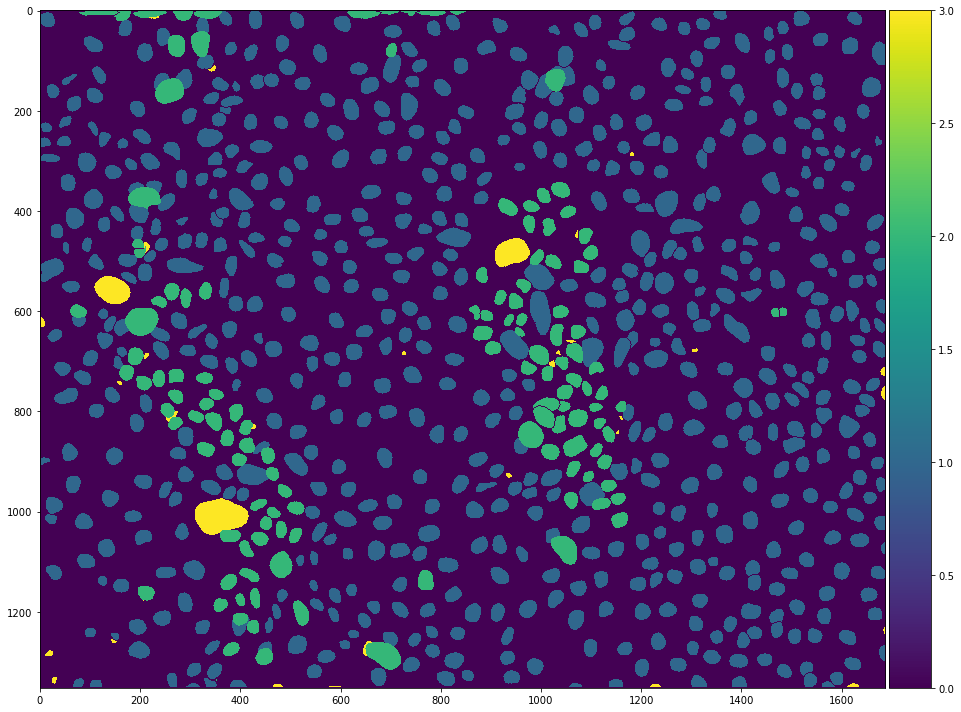

In [102]:
imshow(mask)

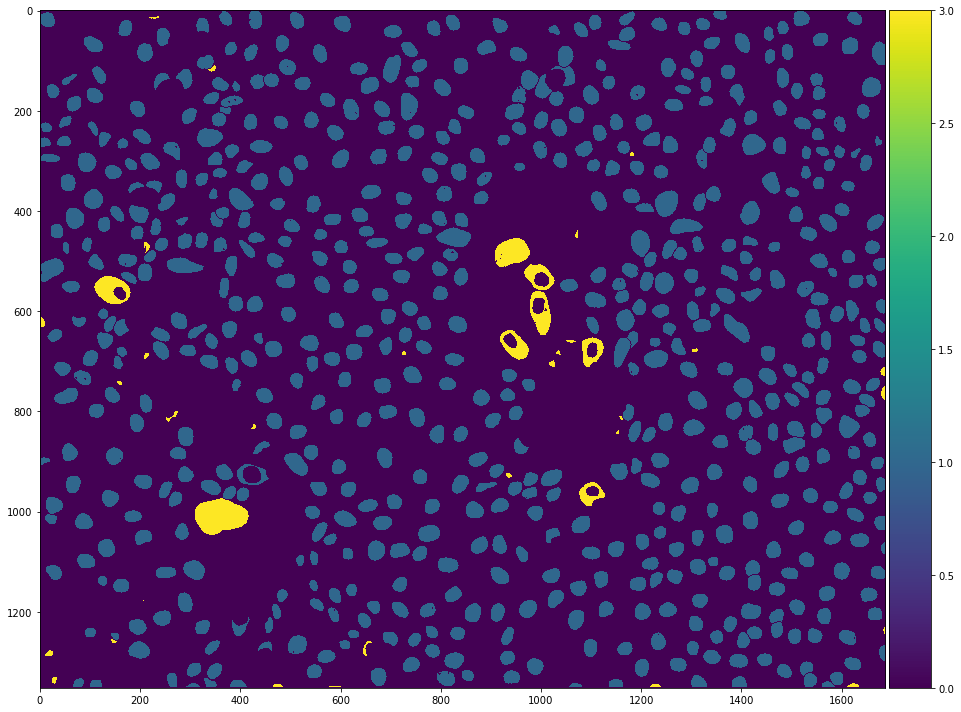

In [93]:
imshow(gfp_mask)

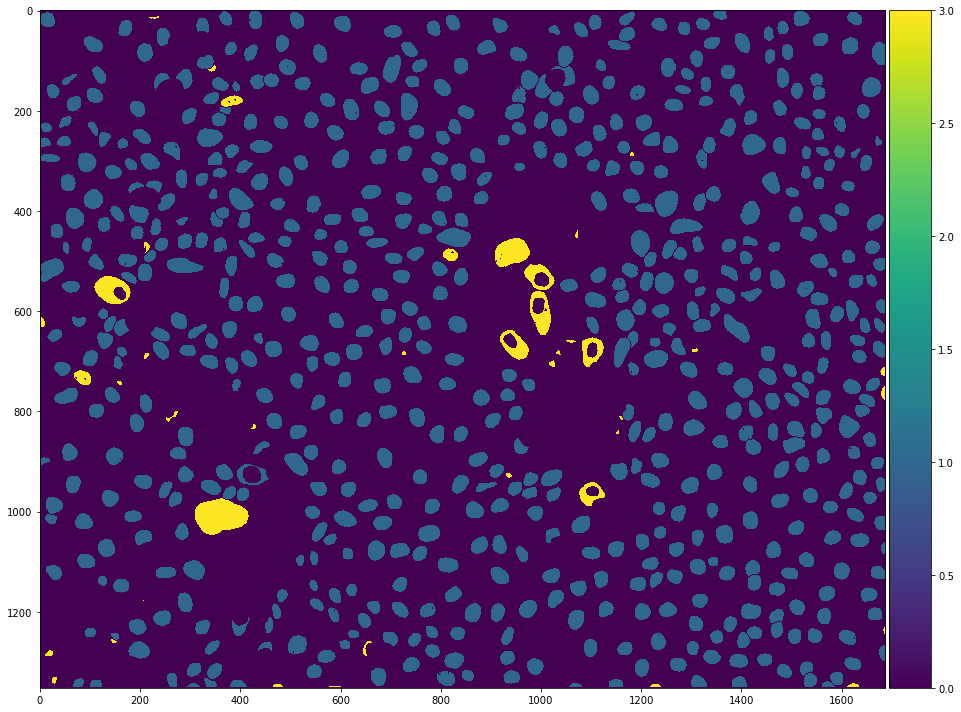

In [62]:
imshow(gfp_mask)

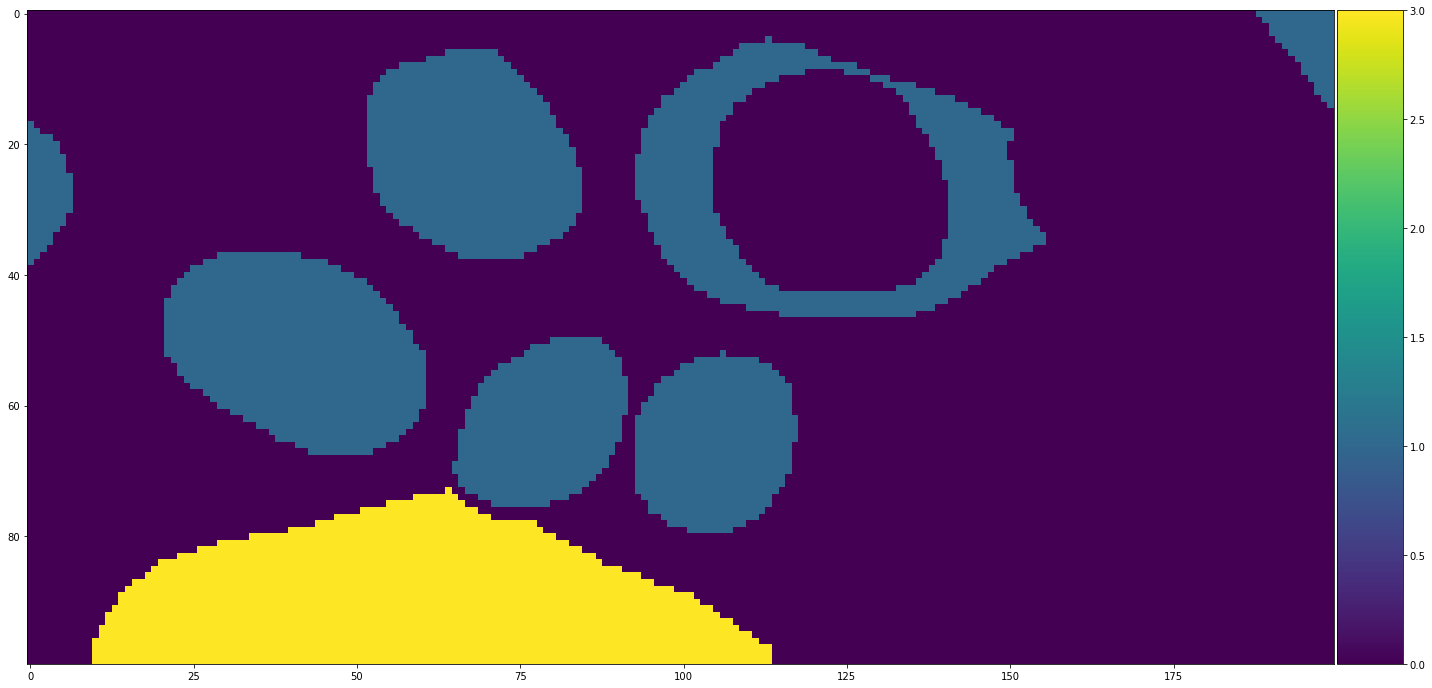

In [63]:
imshow(gfp_mask[900:1000,300:500])

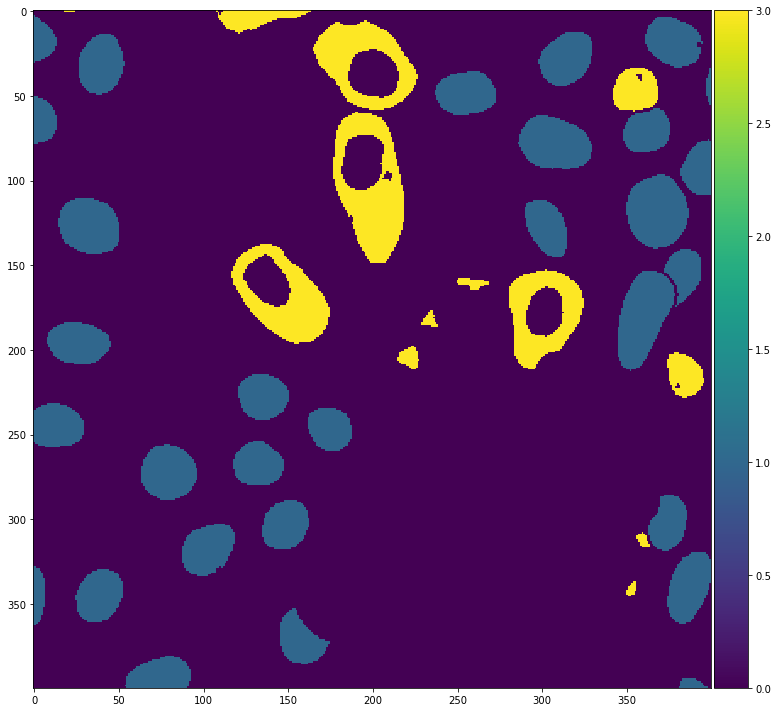

In [45]:
imshow(gfp_mask[500:900,800:1200])

In [64]:
crop =gfp_mask[900:1000,300:500] 

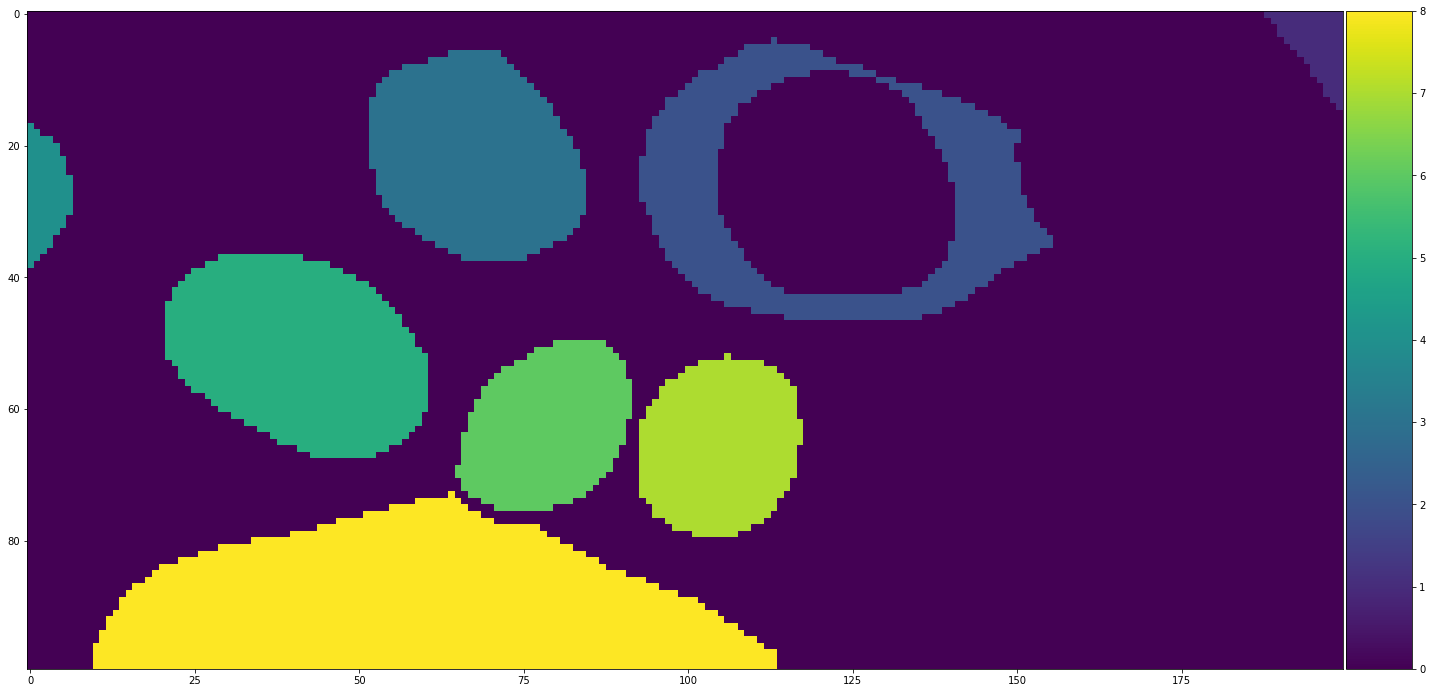

In [65]:
imshow(label(crop))

In [66]:
regionprops(label(crop))[2].area

820

In [67]:
regionprops(label(crop))[2].filled_area

820

In [40]:
regionprops(label(crop))[1].filled_area/2

1107.5

In [41]:
regionprops(label(crop))[3].area

213

In [42]:
regionprops(label(crop))[3].filled_area

213

In [43]:
regionprops(label(crop))[3].filled_area/2

106.5

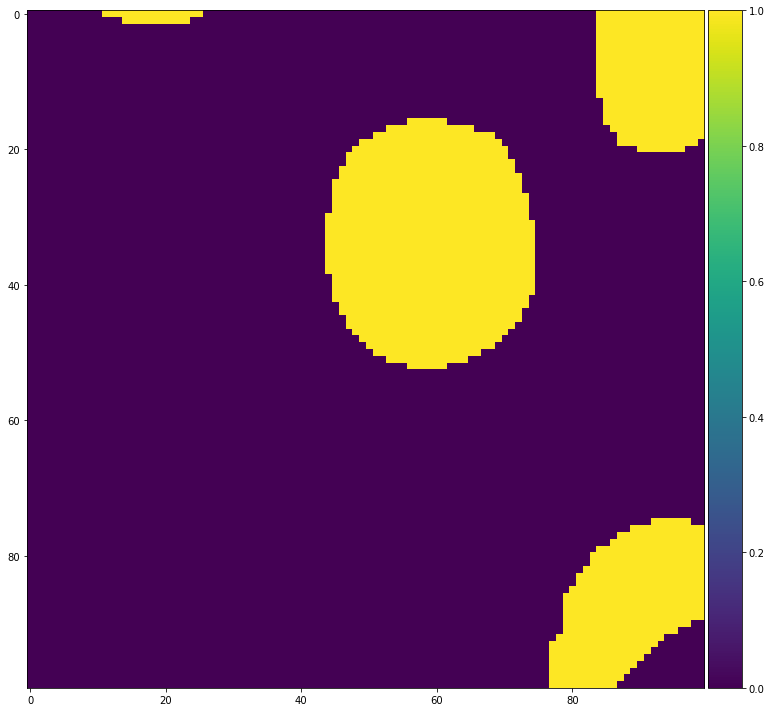

In [20]:
imshow(gfp_mask[900:1000,150:250])

/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


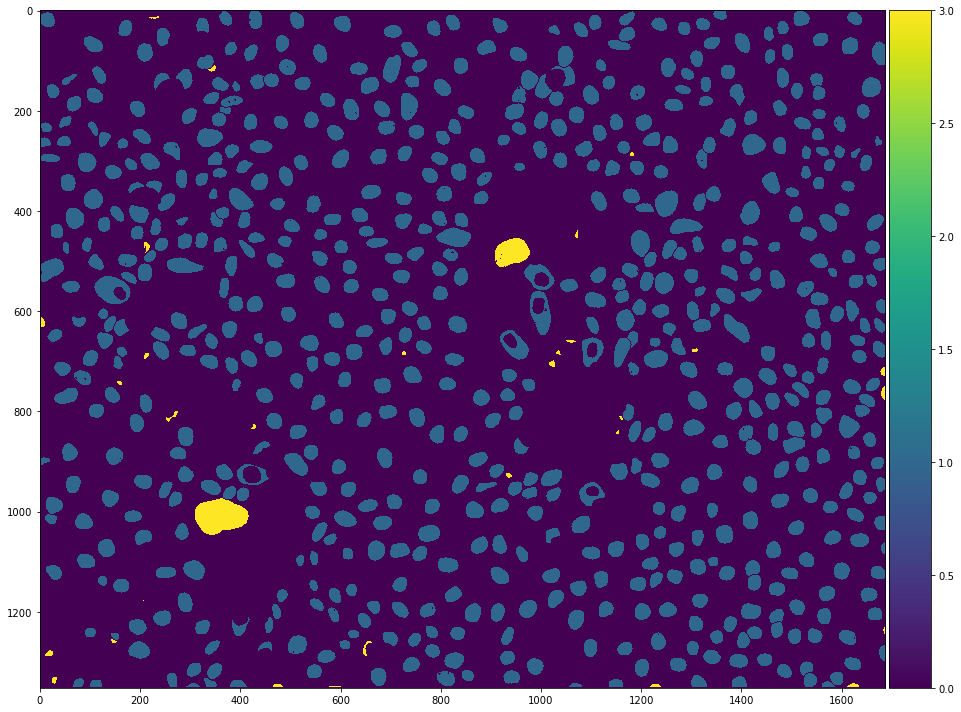

In [14]:
imshow(gfp_mask)

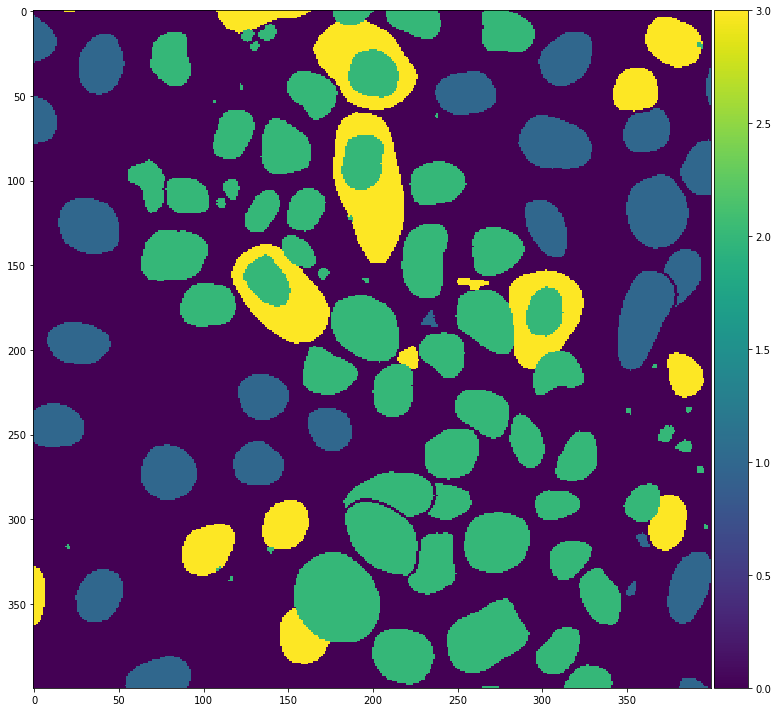

In [34]:
imshow(mask[500:900,800:1200])

In [68]:
#files = images.files('mask')
for fn in tqdm(files):
    # load masks
    fn = files[-1]
    mask = imread(fn).astype(np.uint8)
    gfp_mask = (mask == 1).astype(np.uint8)
    rfp_mask = (mask == 2).astype(np.uint8)
    ## perform post processing for area and ecc
    labels = label(gfp_mask)
    for i in range(1, np.amax(labels)):
        segment = labels == i
        seg_props = regionprops(label(segment))[0]
        if 4000 <= seg_props.area or seg_props.area <= 100 or seg_props.eccentricity > 0.95:
            mask[segment] = 3
#         else:
#             mask[segment] = 1
    ## perform post processing for area and ecc for rfp
    labels = label(rfp_mask)
    for i in range(1, np.amax(labels)):
        segment = labels == i
        seg_props = regionprops(label(segment))[0]
        if 4000 <= seg_props.area or seg_props.area <= 100 or seg_props.eccentricity > 0.95:
            mask[segment] = 3
#         else:
#             mask[segment] = 1
    ## need to redefine cleaned up masks for next step
    gfp_mask = (mask == 1).astype(np.uint8)
    rfp_mask = (mask == 2).astype(np.uint8)
    #perform post processing label assignment on overlaps
    #expand rfp nuclei so they overlap with neighbouring gfp segments
    rfp_mask_exp = seg.expand_labels(rfp_mask, distance = 1) # might need to be 3 for double eroded
    ## create an overlap image
    overlap = ((gfp_mask + rfp_mask_exp*2) == 3).astype(np.uint8)
    ## unqiuely label gfp mask
    labels = label(gfp_mask)
    # iterate over masks finding overlaps and assigning them 3
    for ID in range(1, np.amax(labels)):
        segment = labels == ID
        #if a pixel value of 1 is in the region g_mask[segment]
        if 1 in overlap[segment]:
            mask[segment] = 3
    mask = area_closing(mask)
    
    
    break
#     imsave(fn.replace('channel098', 'channel099'), mask.astype(np.uint8), check_contrast = False)

  0%|          | 0/31423 [00:00<?, ?it/s]

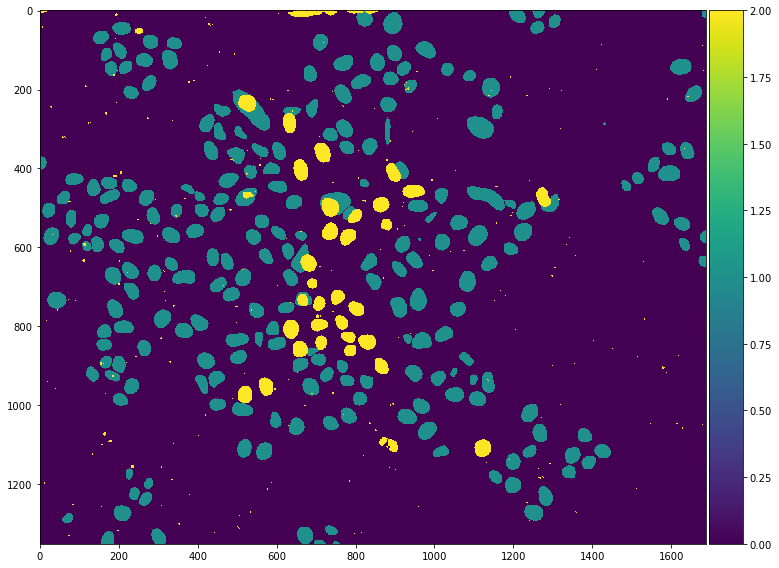

In [61]:
imshow(imread(fn))

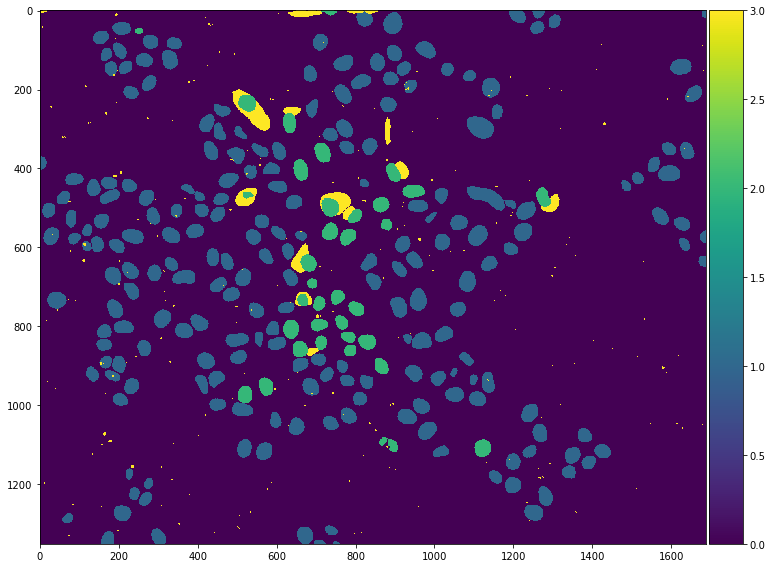

In [69]:
imshow(mask)

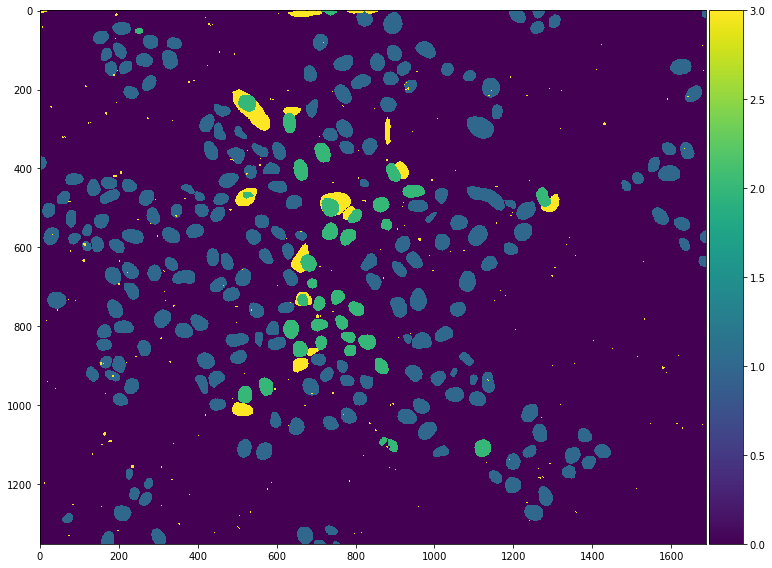

In [67]:
imshow(mask)

In [ ]:
if os.path.exists(fn.replace('channel098', 'channel099')):
        continue
    input_mask = imread(fn)
    labels = label(input_mask==1)

    # format 2channel mask image and post process
    mask = np.zeros(labels.shape, dtype = np.uint8)

    ### image post processing 
    for i in range(1, np.amax(labels)):
        #needs erosion step to stop merging of labels
        segment = labels == i
        seg_props = regionprops(label(segment))[0]
        if 4000 <= seg_props.area or seg_props.area <= 100 or seg_props.eccentricity > 0.95:
            #segment = binary_erosion(segment)
            mask[segment] = 3
        else:
            #segment = binary_erosion(segment)
            mask[segment] = 1

    labels = label(input_mask==2)
    
    ### image post processing 
    for i in range(1, np.amax(labels)):
        #needs erosion step to stop merging of labels
        segment = labels == i
        seg_props = regionprops(label(segment))[0]
        if 4000 <= seg_props.area or seg_props.area <= 100 or seg_props.eccentricity > 0.95:
            #segment = binary_erosion(segment)
            mask[segment] = 3
        else:
            #segment = binary_erosion(segment)
            mask[segment] = 2
            
    imsave(fn.replace('channel098', 'channel099'), mask.astype(np.uint8), check_contrast=False)



# Final formulation

In [133]:
test_files = [fn for fn in files if 'ND0013/Pos7' in fn]

In [138]:
len(test_files)

2797

#### Testing on a subset of ch98 images, saving as ch99 in prep for all ch98 to be saverd as ch99

In [145]:
from natsort import natsorted
from tqdm import trange

In [148]:
import os

In [151]:
for fn in tqdm(natsorted(test_files)):
    mask = imread(fn)
    gfp_mask = label((mask == 1).astype(np.uint8))
    rfp_mask = label((mask == 2).astype(np.uint8))

    ### RFP image post processing first to allow for hot pixels to be deleted
    for i in range(1, np.amax(rfp_mask)):
        #dont need erosion here as these already eroded
        segment = rfp_mask == i
        seg_props = regionprops(label(segment))[0]
        if seg_props.area <= 150:
            mask[segment] = 0
        else:
            #segment = binary_erosion(segment)
            mask[segment] = 2

    ### fill holes of gfp masks with rfp hot pixels in 
    gfp_mask = label(binary_fill_holes(gfp_mask).astype(np.uint8))
    for i in range(1, np.amax(gfp_mask)+1):
        #DOEESNT- already eroded ## needs erosion step to stop merging of labels
        segment = gfp_mask == i
        seg_props = regionprops(label(segment))[0]
        if 3000 <= seg_props.area or seg_props.area <= 150 or seg_props.eccentricity > 0.95 or seg_props.area < (0.9*seg_props.filled_area):
            #segment = binary_erosion(segment)
            mask[segment] = 3
        else:
            #segment = binary_erosion(segment)
            mask[segment] = 1
            
    imsave(fn.replace('channel098', 'channel099'), mask.astype(np.uint8), check_contrast=False)

  0%|          | 0/2797 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [157]:
from skimage.morphology import remove_small_objects, remove_small_holes

/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


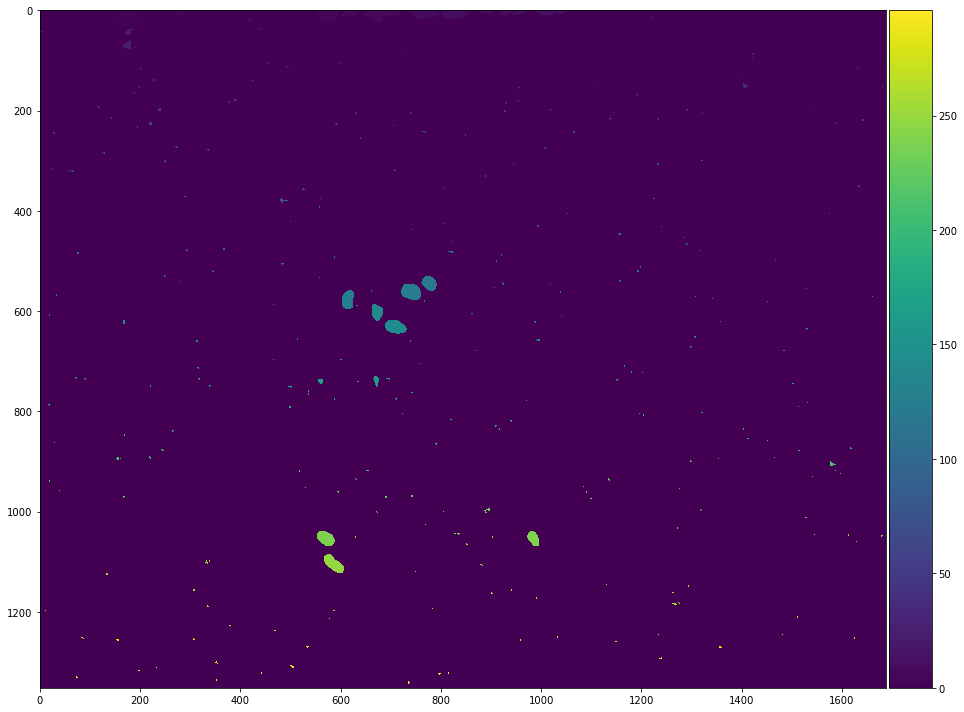

In [153]:
imshow(rfp_mask)

/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


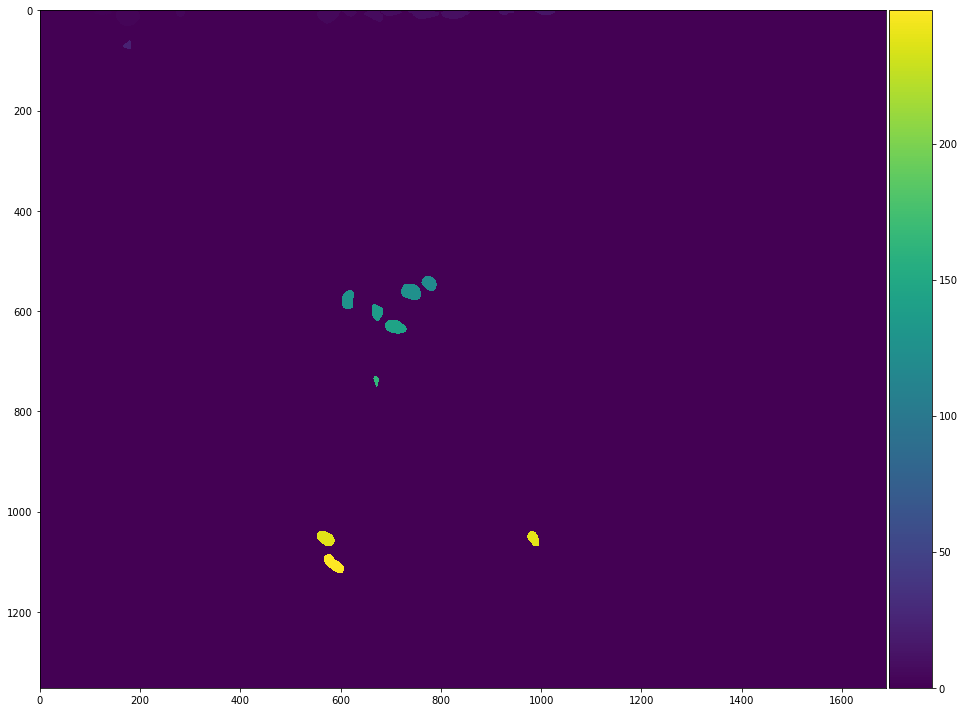

In [156]:
imshow(remove_small_objects(rfp_mask, min_size=150))

In [160]:
gfp_mask = label((mask == 1).astype(np.uint8))

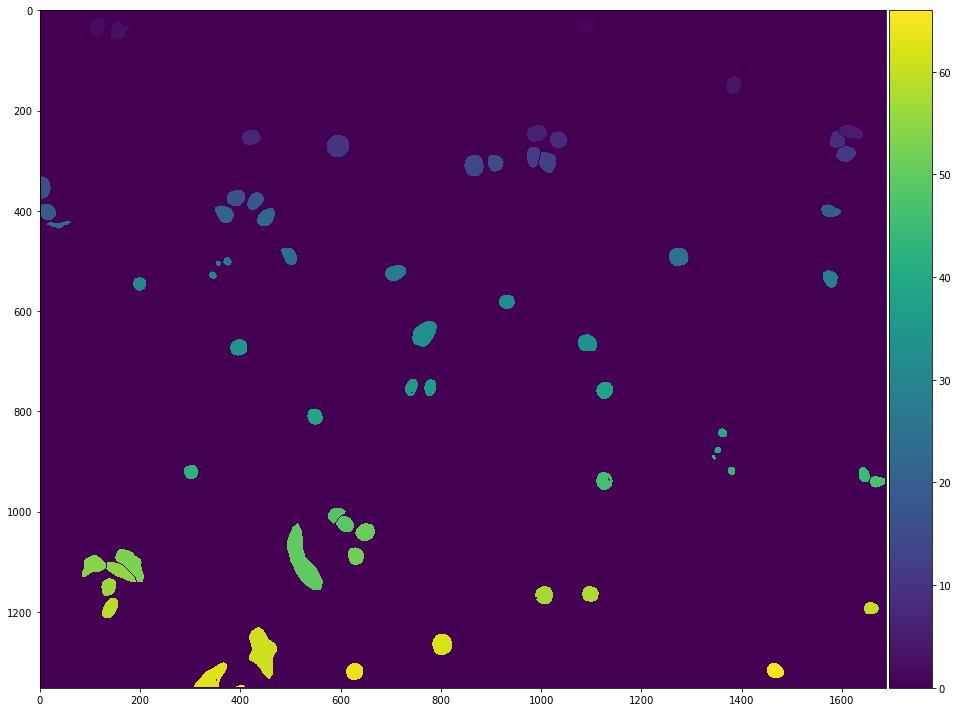

In [161]:
imshow(gfp_mask)

<ipython-input-163-3334ce0b6cb6>:1: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  imshow(remove_small_holes(gfp_mask).astype(int))
/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


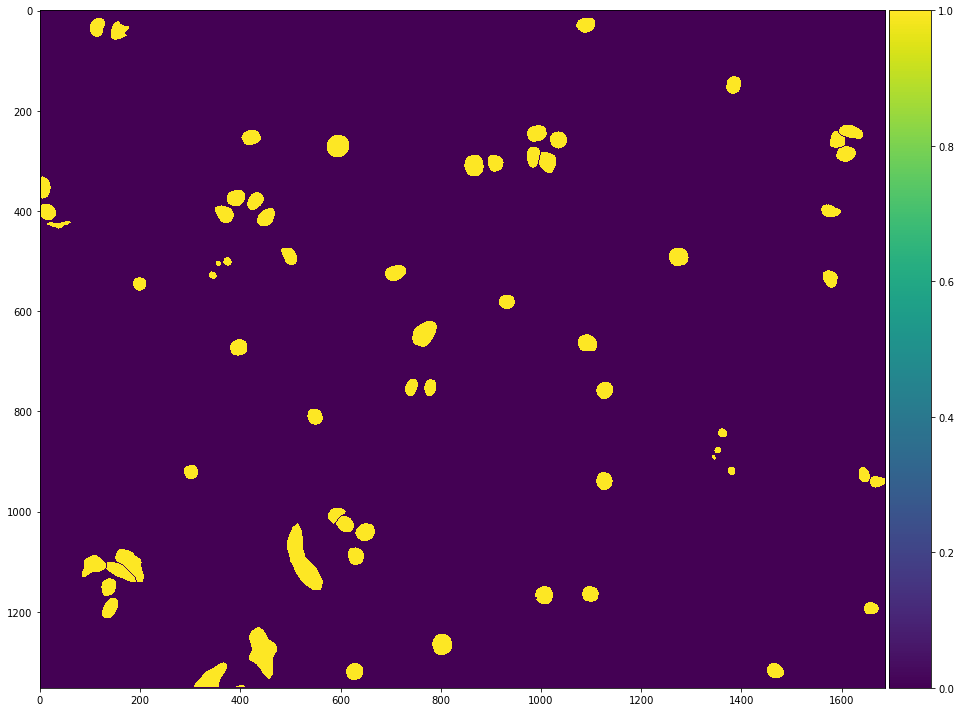

In [163]:
imshow(remove_small_holes(gfp_mask).astype(int))

In [178]:
for fn in tqdm(natsorted(test_files)):
    mask = imread(fn)
    gfp_mask = mask == 1
    rfp_mask = mask == 2

    rfp_mask = remove_small_objects(rfp_mask, min_size=150).astype(np.uint8)*2
    gfp_mask = label(remove_small_objects(remove_small_holes(gfp_mask), min_size=150))

    for i in range(1, np.amax(gfp_mask)+1):
        #DOEESNT- already eroded ## needs erosion step to stop merging of labels
        segment = gfp_mask == i
        seg_props = regionprops(label(segment))[0]
        if 3000 <= seg_props.area or seg_props.eccentricity > 0.95 or seg_props.area < (0.9*seg_props.filled_area):
            #segment = binary_erosion(segment)
            gfp_mask[segment] = 3
        else:
            #segment = binary_erosion(segment)
            gfp_mask[segment] = 1
    
    mask = gfp_mask.astype(np.uint8) + rfp_mask.astype(np.uint8)
    
    imsave(fn.replace('channel098', 'channel099'), mask.astype(np.uint8), check_contrast=False)

  0%|          | 0/2797 [00:00<?, ?it/s]

# Redefining the upper size bound

2000 pixels caught too many large gfp nuclei, redefining to 3000

In [4]:
files = glob.glob('/home/nathan/data/kraken/ras/ND****/Pos*/Pos*_images/*channel099*.tif')

In [5]:
len(files)

53354

In [29]:
fn

'/home/nathan/data/kraken/ras/ND0013/Pos7/Pos7_images/img_channel099_position007_time000000000_z000.tif'

In [54]:
files[23900]

'/home/nathan/data/kraken/ras/ND0017/Pos4/Pos4_images/img_channel099_position004_time000000470_z000.tif'

In [57]:
for fn in tqdm(natsorted(files)):

    ### only 3pix value objects remain
    mask = imread(fn) 
    mask_3 = (mask == 3)*3

    labelled_mask = label(mask_3)
    for i in range(1, np.amax(labelled_mask)+1):
        segment = labelled_mask == i
        seg_props = regionprops(label(segment), cache=False)[0]
#         print(seg_props.area, seg_props.filled_area, seg_props.area/seg_props.filled_area, seg_props.eccentricity)
        if 2000 <= seg_props.area <= 3000 and seg_props.area > (0.9*seg_props.filled_area) and seg_props.eccentricity < 0.95:
            mask[segment] = 1


        imsave(fn, mask.astype(np.uint8), check_contrast=False)

       # break

  0%|          | 0/53354 [00:00<?, ?it/s]

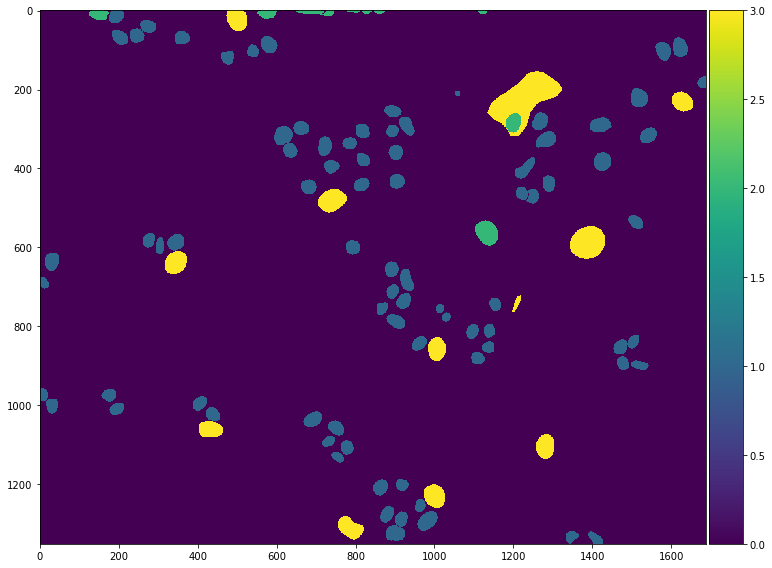

In [51]:
imshow(imread(files[23900]))

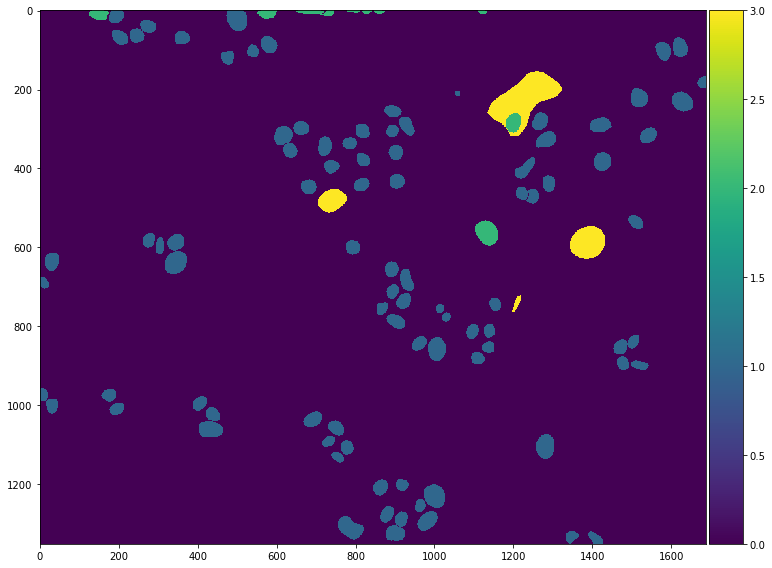

In [52]:
imshow(mask.astype(int))

# Clearing out the deadwood

In [58]:
old_files = glob.glob('/home/nathan/data/kraken/ras/ND**/Pos*/Pos*_images/*channel098*')

In [59]:
len(old_files)

31423

In [61]:
old_tracks = glob.glob('/home/nathan/data/kraken/ras/ND**/Pos*/*.h5')

In [62]:
len(old_tracks)

178

In [63]:
old_tracks[0]

'/home/nathan/data/kraken/ras/ND0013/Pos7/old_old_objects.h5'

In [68]:
### filter old tracks for new h5s

old_tracks = [file for file in old_tracks if 'old' in file]
#  if not 'ND0022/Pos5' 
#  or 'ND0022/Pos4' in file or]

In [70]:
for fn in tqdm(old_files):
    os.remove(fn)

  0%|          | 0/31423 [00:00<?, ?it/s]

In [71]:
for fn in tqdm(old_tracks):
    os.remove(fn)

  0%|          | 0/171 [00:00<?, ?it/s]

In [72]:
old_files = glob.glob('/home/nathan/data/kraken/ras/ND**/Pos*/Pos*_images/*channel09*')

In [73]:
old_files = [fn for fn in old_files if 'channel099' not in fn]

In [75]:
for fn in tqdm(old_files):
    os.remove(fn)

  0%|          | 0/14592 [00:00<?, ?it/s]